
0. 메모리 문제가 발생해서 anomaly를 확인할 수 없다.
-> tsne로 데이터 사이즈를 줄이니까 15분 정도 만에 leverage 값이 산출이 되지만 뭐가 anomaly인지 확인할 수 없다.

1. anomaly를 주입한 데이터에서 anomaly에 해당하는 데이터 프레임을 뽑아낸다.

2. test result 파일이랑 tsne result 파일의 anomaly들이 어떤 숫자값 특성을 갖고 있는지 확인하고(패턴 확인에 챗gpt 도움을 받을 수도 있음) 일치율을 확인한다. 


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df1 = pd.read_csv('result_table/result_pca_insert0.003_bpic2012_O_ACCEPTED-COMPLETE_clean.csv')
df2 = pd.read_csv('result_table/result_tsne_insert0.003_bpic2012_O_ACCEPTED-COMPLETE_clean.csv')
df3 = pd.read_csv('result_table/result_umap_insert0.003_bpic2012_O_ACCEPTED-COMPLETE_clean.csv')

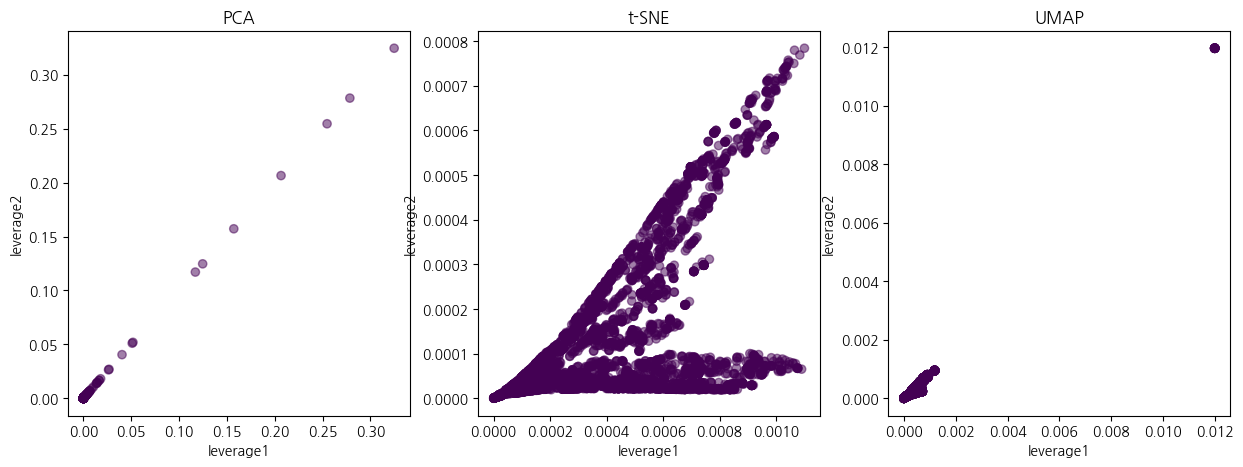

In [3]:
# leverage1, leverage2 값에 대한 그래프를 각각 그리기

plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.scatter(df1['leverage1'], df1['leverage2'], c=df1['label'], alpha=0.5)
plt.title('PCA')
plt.xlabel('leverage1')
plt.ylabel('leverage2')
plt.subplot(1, 3, 2)
plt.scatter(df2['leverage1'], df2['leverage2'], c=df2['label'], alpha=0.5)
plt.title('t-SNE')
plt.xlabel('leverage1')
plt.ylabel('leverage2')
plt.subplot(1, 3, 3)
plt.scatter(df3['leverage1'], df3['leverage2'], c=df3['label'], alpha=0.5)
plt.title('UMAP')
plt.xlabel('leverage1')
plt.ylabel('leverage2')
plt.show()

In [21]:
# Load the data
test_df = pd.read_csv('result_table/test_1.csv')
pca_df = pd.read_csv('result_table/result_pca_insert0.003_bpic2012_O_ACCEPTED-COMPLETE_clean.csv')
tsne_df = pd.read_csv('result_table/result_tsne_insert0.003_bpic2012_O_ACCEPTED-COMPLETE_clean.csv')
umap_df = pd.read_csv('result_table/result_umap_insert0.003_bpic2012_O_ACCEPTED-COMPLETE_clean.csv')

# Assuming 'leverage1' and 'leverage2' columns exist in these dataframes
leverage1_test = test_df['leverage1']
leverage2_test = test_df['leverage2']
leverage1_pca = pca_df['leverage1']
leverage2_pca = pca_df['leverage2']
leverage1_tsne = tsne_df['leverage1']
leverage2_tsne = tsne_df['leverage2']
leverage1_umap = umap_df['leverage1']
leverage2_umap = umap_df['leverage2']

# Combine data for comparison
leverage_data = {
    'Test': (leverage1_test, leverage2_test),
    'PCA': (leverage1_pca, leverage2_pca),
    'TSNE': (leverage1_tsne, leverage2_tsne),
    'UMAP': (leverage1_umap, leverage2_umap)
}

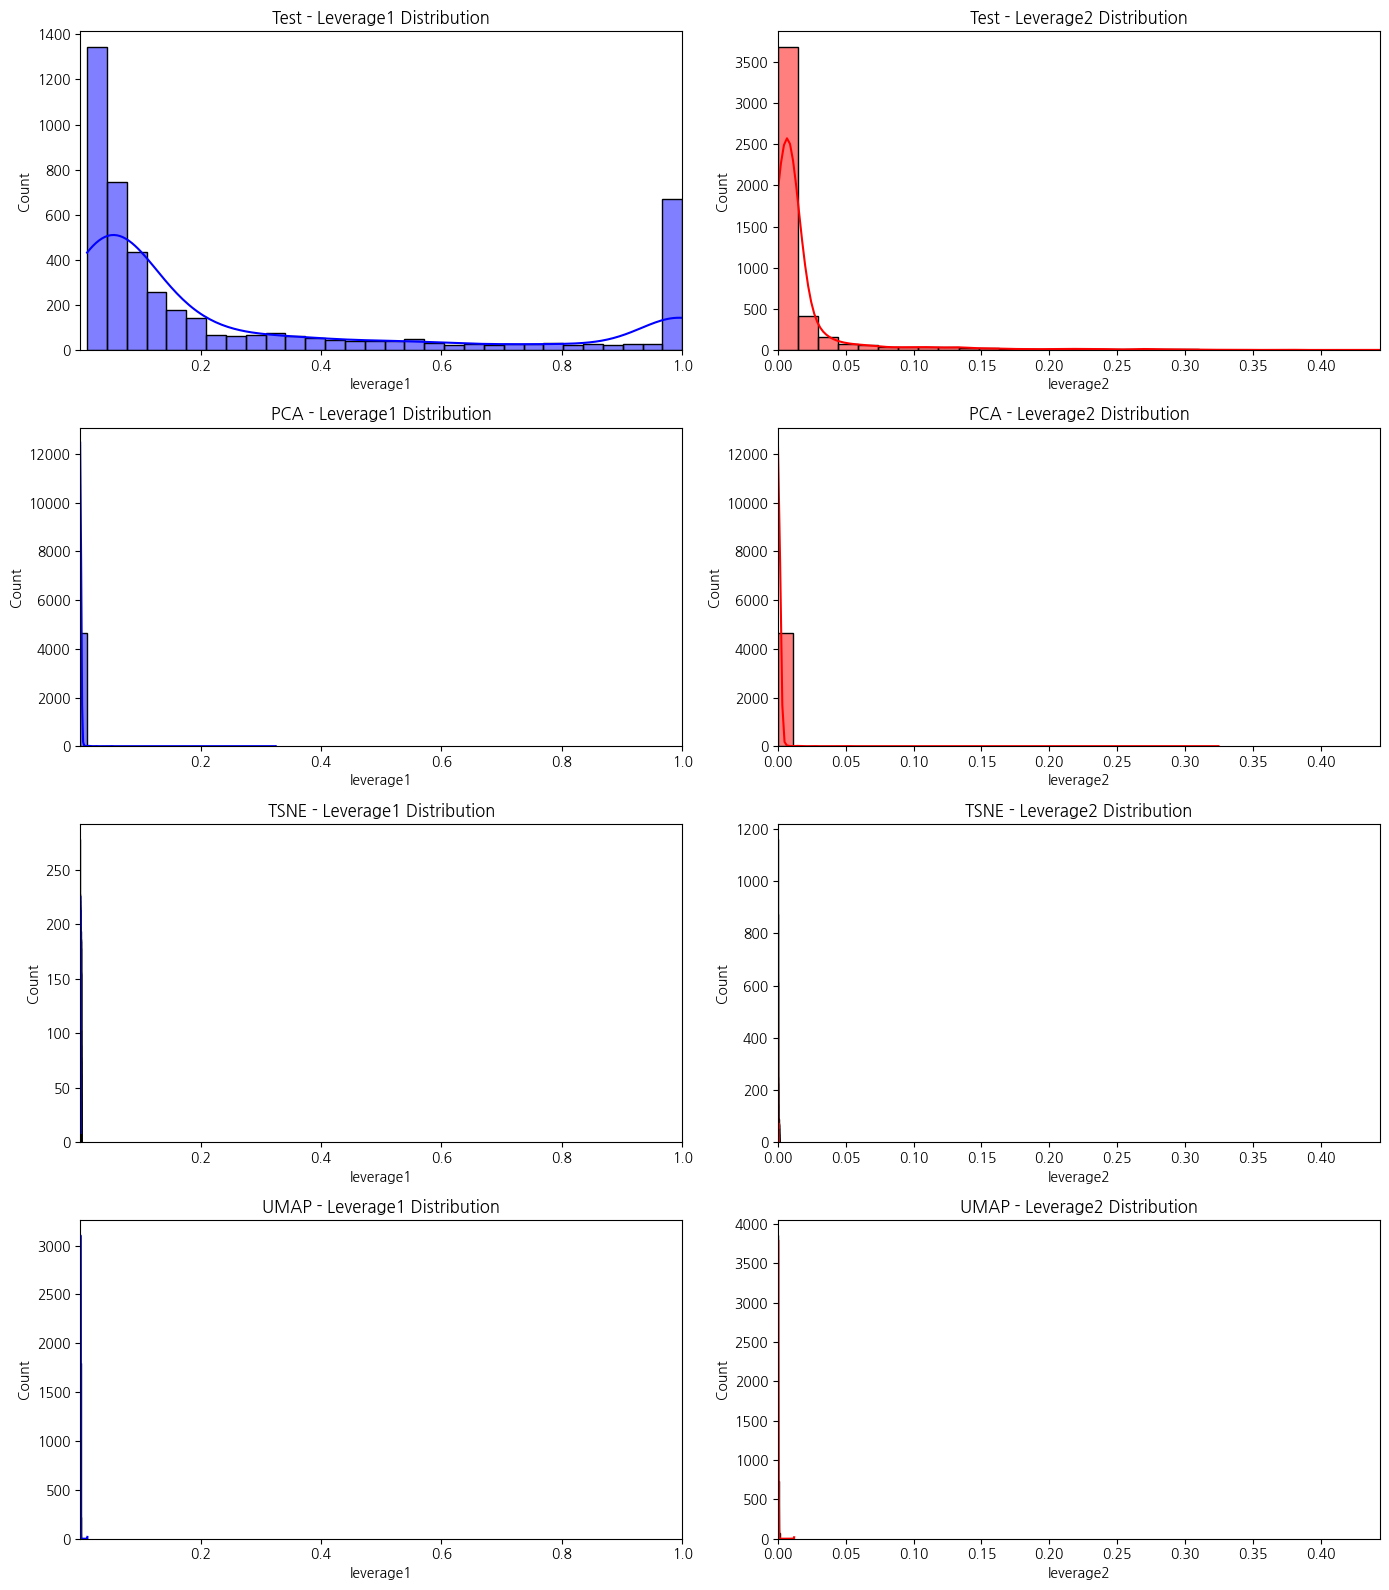

In [33]:
# Find global x-axis limits
leverage1_all = pd.concat([leverage1_test, leverage1_pca, leverage1_tsne, leverage1_umap])
leverage2_all = pd.concat([leverage2_test, leverage2_pca, leverage2_tsne, leverage2_umap])
xlim1 = (leverage1_all.min(), leverage1_all.max())
xlim2 = (leverage2_all.min(), leverage2_all.max())

# Histograms
fig, axs = plt.subplots(4, 2, figsize=(14, 16))

for i, (method, (lev1, lev2)) in enumerate(leverage_data.items()):
    sns.histplot(lev1, bins=30, kde=True, ax=axs[i, 0], color='blue')
    axs[i, 0].set_title(f'{method} - Leverage1 Distribution')
    axs[i, 0].set_xlim(xlim1)
    
    sns.histplot(lev2, bins=30, kde=True, ax=axs[i, 1], color='red')
    axs[i, 1].set_title(f'{method} - Leverage2 Distribution')
    axs[i, 1].set_xlim(xlim2)

plt.tight_layout()
plt.savefig('leverage_histograms_combined.png')
plt.show()

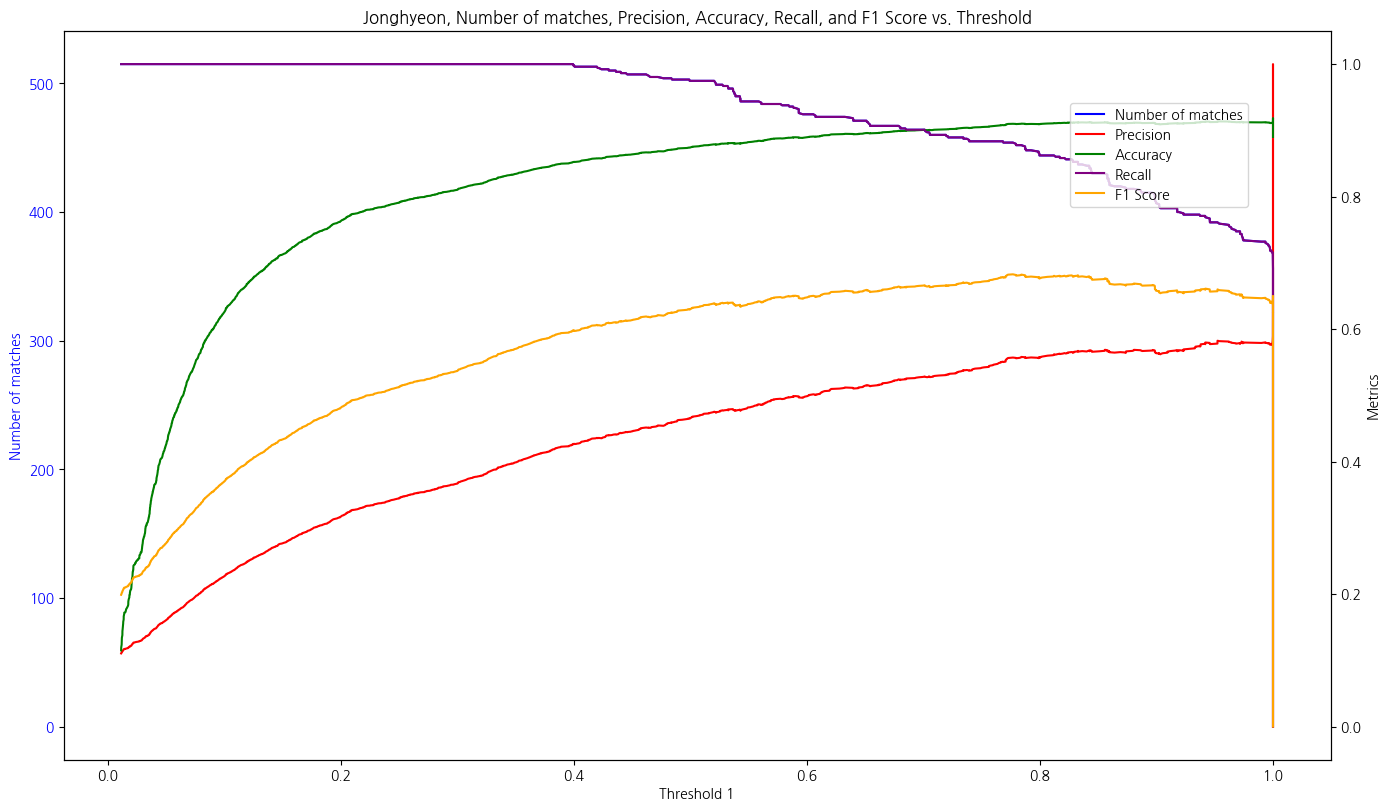

In [42]:
# Load the CSV files
abnormal_cases_df = pd.read_csv('abnormal_cases.csv')
data = pd.read_csv('result_table/test_1.csv')

# Convert caseid in abnormal_cases to a set for fast lookup
abnormal_case_ids = set(abnormal_cases_df['0'])
# 매칭 수, 정밀도, 정확도, 리콜, F1 점수를 계산하는 함수
def calculate_metrics(threshold, abnormal_case_ids, data):
    # 현재 임계값보다 leverage2이 큰 data의 caseid를 찾기
    test_case_ids = set(data[data['leverage1'] > threshold]['caseid'])
    
    # 비정상 사례와의 매칭 수 계산
    matches = len(abnormal_case_ids.intersection(test_case_ids))
    
    TP = matches
    FP = len(test_case_ids) - matches
    FN = len(abnormal_case_ids) - matches
    TN = len(data) - (TP + FP + FN)
    # 정밀도 계산
    precision = matches / (TP + FP) if (TP + FP) > 0 else 0
    
    # 리콜 계산
    recall = matches / (TP + FN) if (TP + FN) > 0 else 0
    
    # 정확도 계산
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    
    # F1 점수 계산
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return matches, precision, accuracy, recall, f1_score

# 변수 초기화
thresholds = sorted(data['leverage1'].unique())
matches = []
precisions = []
accuracies = []
recalls = []
f1_scores = []

# 각 임계값에 대해 매칭 수, 정밀도, 정확도, 리콜, F1 점수 계산
for threshold in thresholds:
    match, precision, accuracy, recall, f1_score = calculate_metrics(threshold, abnormal_case_ids, data)
    matches.append(match)
    precisions.append(precision)
    accuracies.append(accuracy)
    recalls.append(recall)
    f1_scores.append(f1_score)

# 하나의 그래프에 모든 지표를 나타내기
fig, ax1 = plt.subplots(figsize=(14, 8))

ax1.set_xlabel('Threshold 1')
ax1.set_ylabel('Number of matches', color='blue')
ax1.plot(thresholds, matches, color='blue', label='Number of matches')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()  # 두 번째 y축을 공유하는 새로운 축
ax2.set_ylabel('Metrics', color='black')
ax2.plot(thresholds, precisions, color='red', label='Precision')
ax2.plot(thresholds, accuracies, color='green', label='Accuracy')
ax2.plot(thresholds, recalls, color='purple', label='Recall')
ax2.plot(thresholds, f1_scores, color='orange', label='F1 Score')
ax2.tick_params(axis='y', labelcolor='black')

fig.tight_layout()  # 레이아웃 조정
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.title('Jonghyeon, Number of matches, Precision, Accuracy, Recall, and F1 Score vs. Threshold')
plt.show()

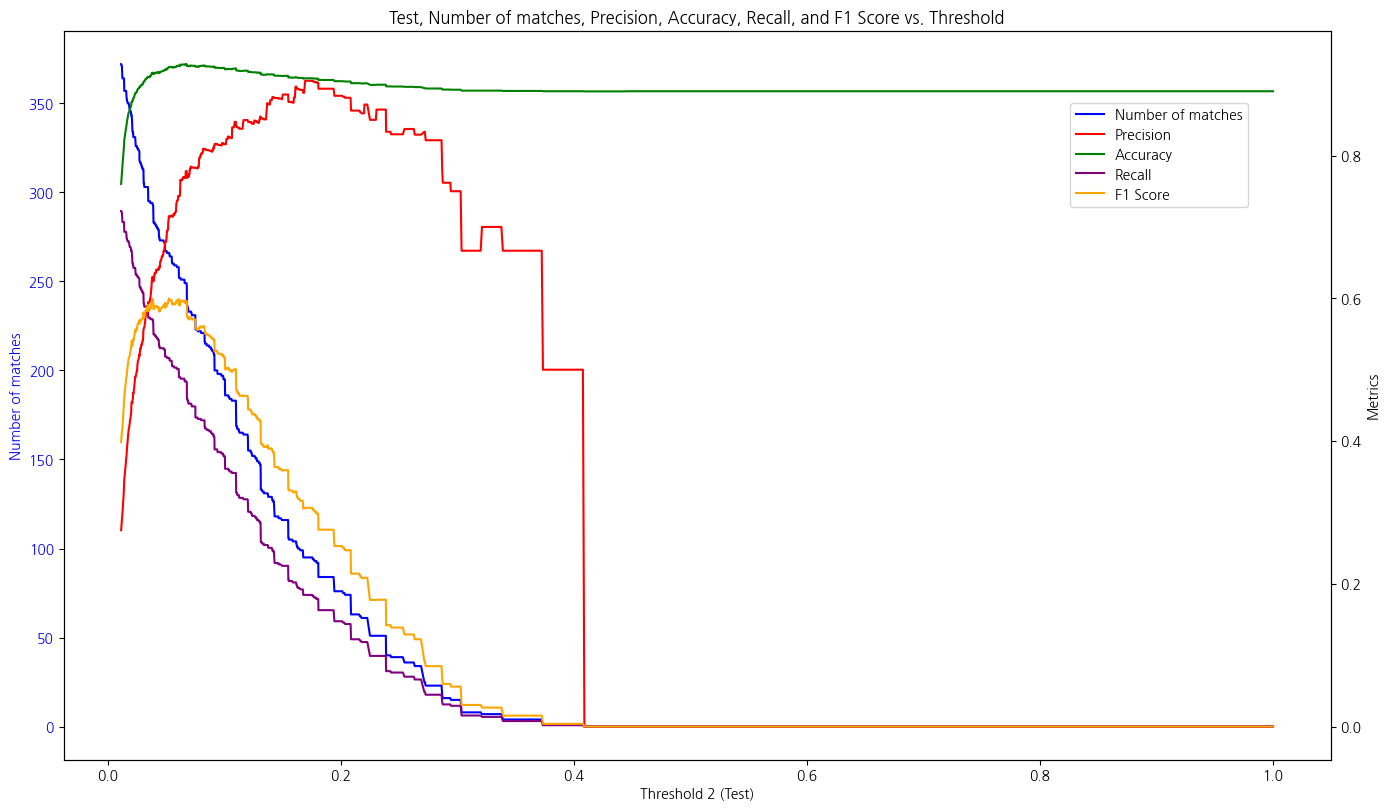

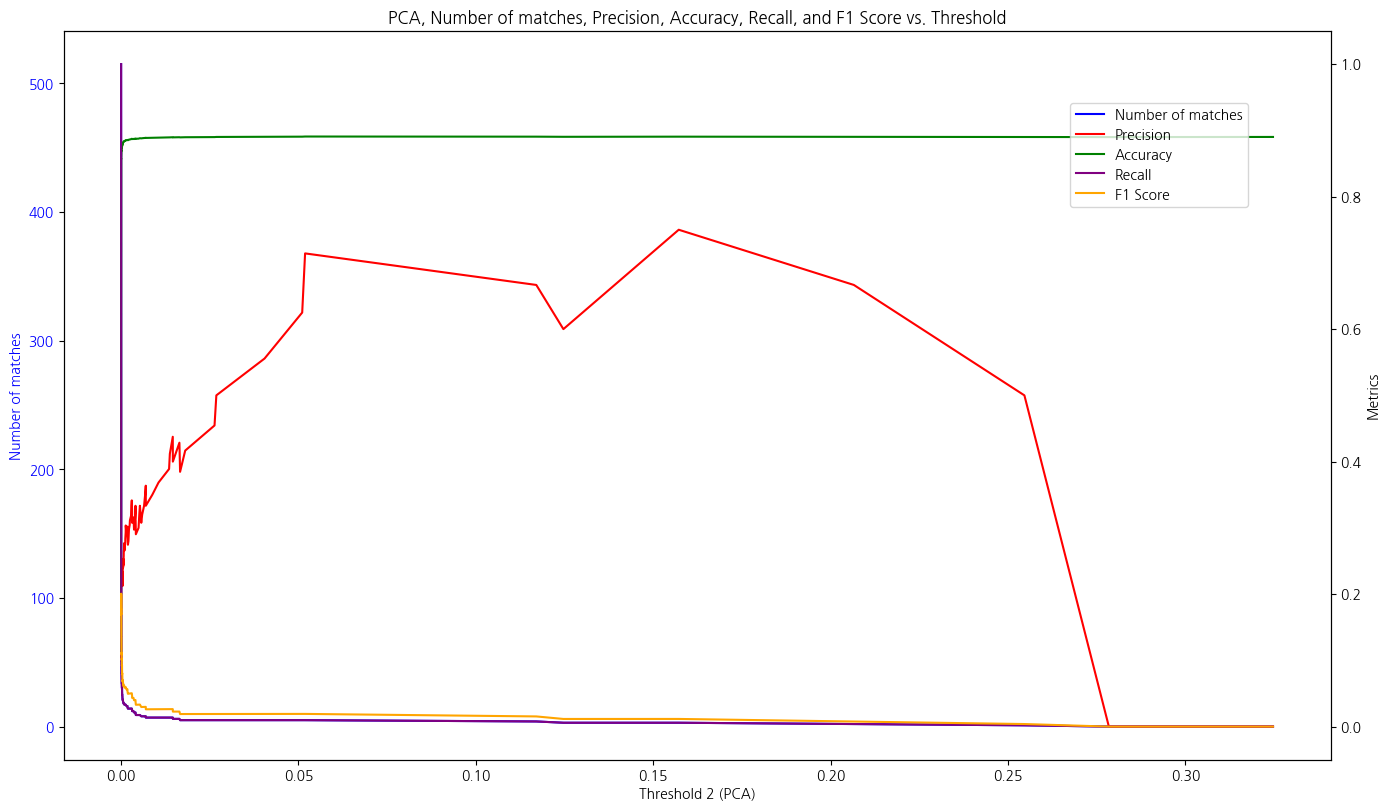

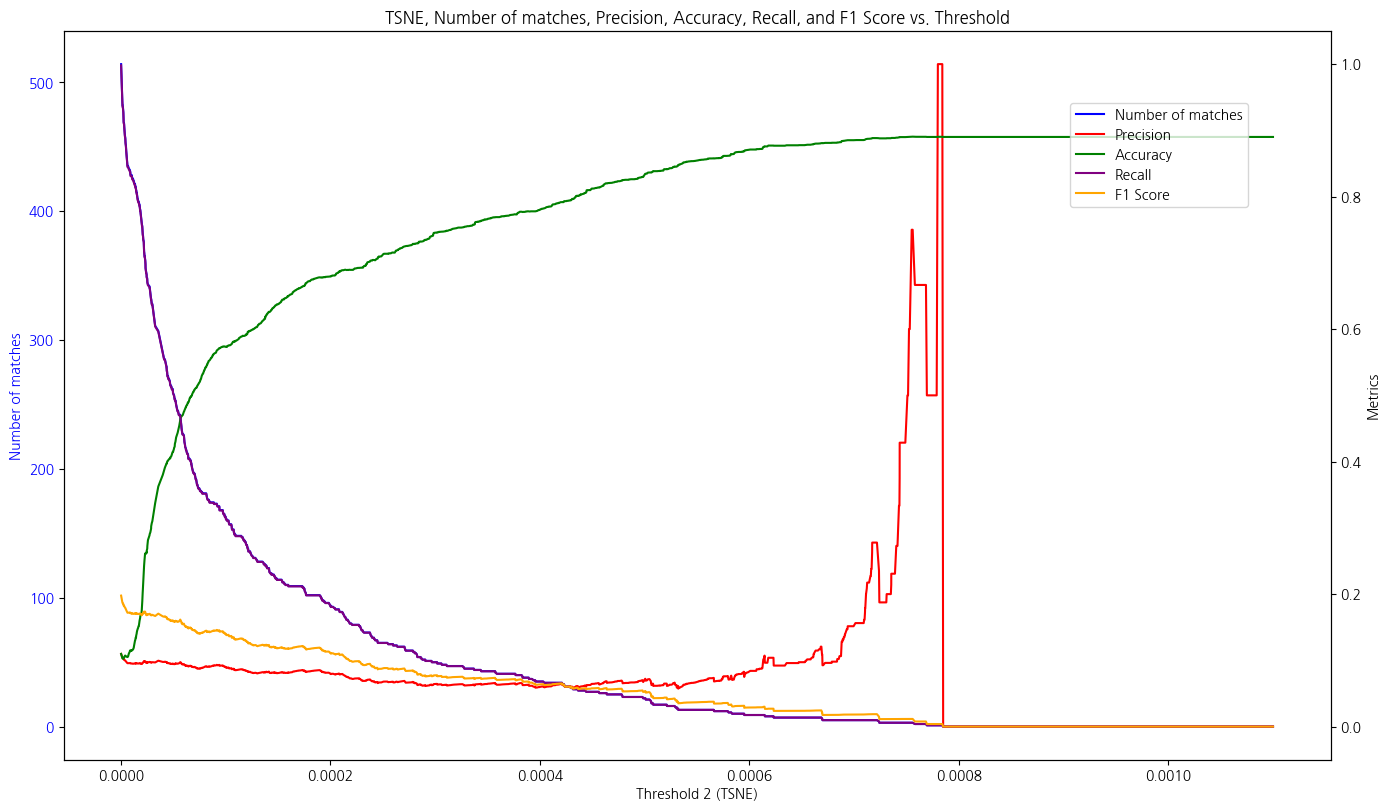

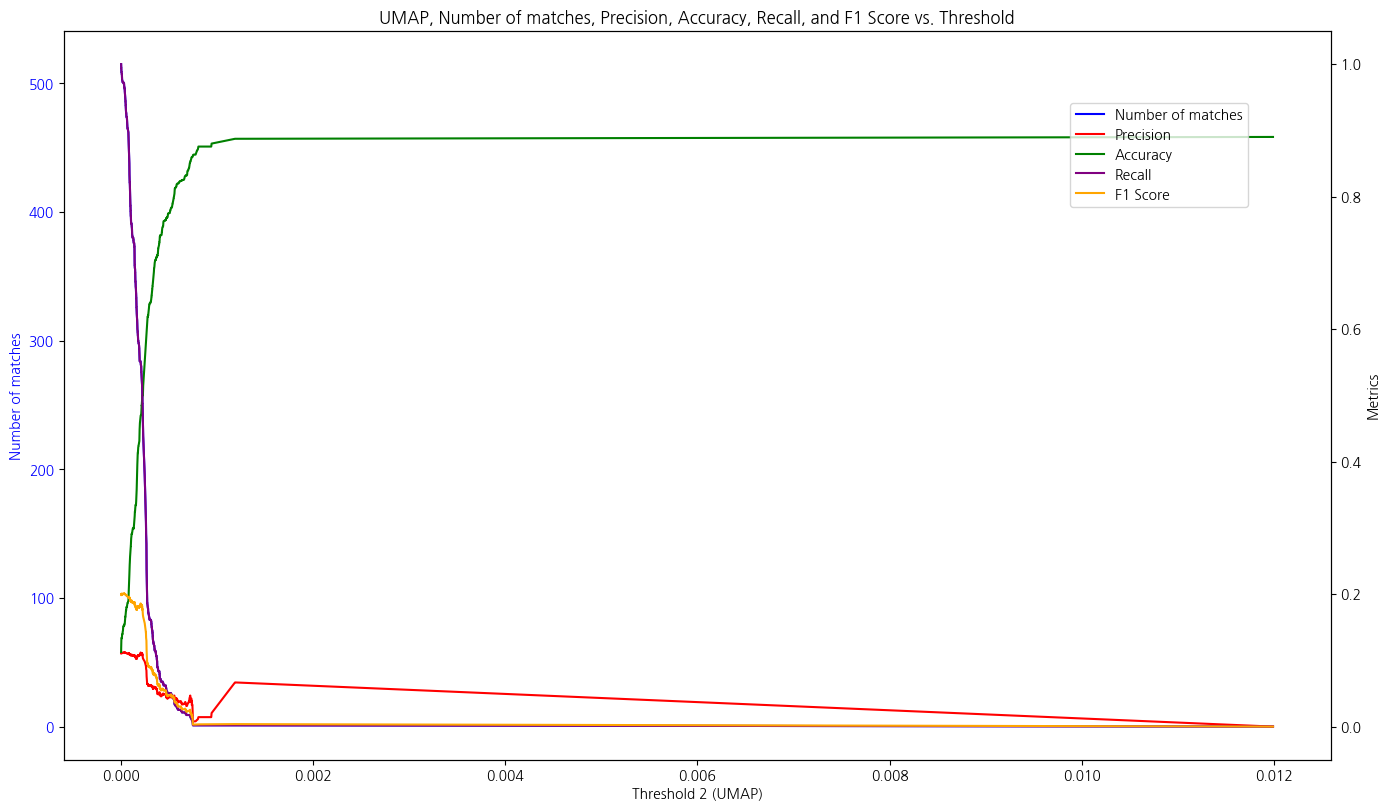

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV files
abnormal_cases_df = pd.read_csv('abnormal_cases.csv')
data1 = pd.read_csv('result_table/test_1.csv') 
data2 = pd.read_csv('result_table/result_pca_insert0.003_bpic2012_O_ACCEPTED-COMPLETE_clean.csv')
data3 = pd.read_csv('result_table/result_tsne_insert0.003_bpic2012_O_ACCEPTED-COMPLETE_clean.csv')
data4 = pd.read_csv('result_table/result_umap_insert0.003_bpic2012_O_ACCEPTED-COMPLETE_clean.csv')

# Convert caseid in abnormal_cases to a set for fast lookup
abnormal_case_ids = set(abnormal_cases_df['0'])

# 매칭 수, 정밀도, 정확도, 리콜, F1 점수를 계산하는 함수
def calculate_metrics(threshold, abnormal_case_ids, data):
    # 현재 임계값보다 leverage1이 큰 data의 caseid를 찾기
    try:
        test_case_ids = set(data[data['leverage2'] > threshold]['caseid'])
    except: test_case_ids = set(data[data['leverage2'] > threshold]['Case'])
    
    # 비정상 사례와의 매칭 수 계산
    matches = len(abnormal_case_ids.intersection(test_case_ids))
    
    TP = matches
    FP = len(test_case_ids) - matches
    FN = len(abnormal_case_ids) - matches
    TN = len(data) - (TP + FP + FN)
    
    # 정밀도 계산
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    # 리콜 계산
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    # 정확도 계산
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    
    # F1 점수 계산
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return matches, precision, accuracy, recall, f1_score

# 데이터셋 목록
datasets = {
    'Test': data1,
    'PCA': data2,
    'TSNE': data3,
    'UMAP': data4
}

# 각 데이터셋에 대해 지표를 계산하고 그래프를 그리기
for name, data in datasets.items():
    thresholds = sorted(data['leverage1'].unique())
    matches = []
    precisions = []
    accuracies = []
    recalls = []
    f1_scores = []

    for threshold in thresholds:
        match, precision, accuracy, recall, f1_score = calculate_metrics(threshold, abnormal_case_ids, data)
        matches.append(match)
        precisions.append(precision)
        accuracies.append(accuracy)
        recalls.append(recall)
        f1_scores.append(f1_score)
    
    # 하나의 그래프에 모든 지표를 나타내기
    fig, ax1 = plt.subplots(figsize=(14, 8))

    ax1.set_xlabel(f'Threshold 2 ({name})')
    ax1.set_ylabel('Number of matches', color='blue')
    ax1.plot(thresholds, matches, color='blue', label='Number of matches')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()  # 두 번째 y축을 공유하는 새로운 축
    ax2.set_ylabel('Metrics', color='black')
    ax2.plot(thresholds, precisions, color='red', label='Precision')
    ax2.plot(thresholds, accuracies, color='green', label='Accuracy')
    ax2.plot(thresholds, recalls, color='purple', label='Recall')
    ax2.plot(thresholds, f1_scores, color='orange', label='F1 Score')
    ax2.tick_params(axis='y', labelcolor='black')

    fig.tight_layout()  # 레이아웃 조정
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
    plt.title(f'{name}, Number of matches, Precision, Accuracy, Recall, and F1 Score vs. Threshold')
    plt.show()


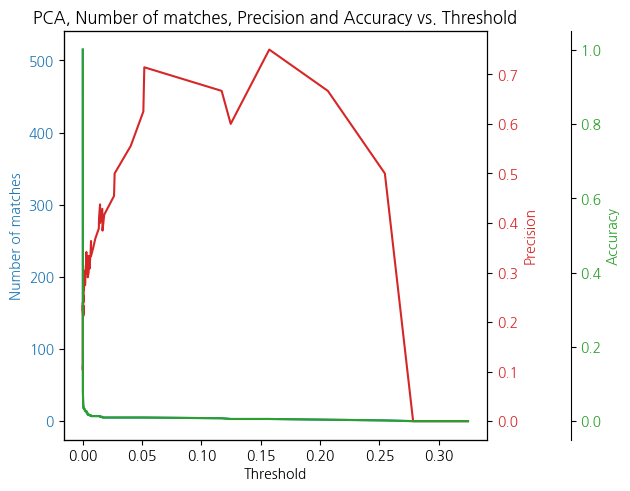

In [27]:
# Load the CSV files
abnormal_cases_df = pd.read_csv('abnormal_cases.csv')
data = df1

# Convert caseid in abnormal_cases to a set for fast lookup
abnormal_case_ids = set(abnormal_cases_df['0'])

# 매칭 수, 정밀도, 정확도를 계산하는 함수
def calculate_metrics(threshold, abnormal_case_ids, data):
    # 현재 임계값보다 leverage2가 큰 test_1의 caseid를 찾기
    test_case_ids = set(data[data['leverage1'] > threshold]['Case'])
    
    # 비정상 사례와의 매칭 수 계산
    matches = len(abnormal_case_ids.intersection(test_case_ids))
    
    # 정밀도 계산
    precision = matches / len(test_case_ids) if len(test_case_ids) > 0 else 0
    
    # 정확도 계산
    accuracy = matches / len(abnormal_case_ids) if len(abnormal_case_ids) > 0 else 0
    
    return matches, precision, accuracy

# 변수 초기화
thresholds = sorted(data['leverage1'].unique())
matches = []
precisions = []
accuracies = []

# 각 임계값에 대해 매칭 수, 정밀도, 정확도 계산
for threshold in thresholds:
    match, precision, accuracy = calculate_metrics(threshold, abnormal_case_ids, data)
    matches.append(match)
    precisions.append(precision)
    accuracies.append(accuracy)

# 매칭 수, 정밀도, 정확도 vs. 임계값 그래프
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Number of matches', color=color)
ax1.plot(thresholds, matches, color=color, label='Number of matches')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # 두 번째 y축을 공유하는 새로운 축
color = 'tab:red'
ax2.set_ylabel('Precision', color=color)
ax2.plot(thresholds, precisions, color=color, label='Precision')
ax2.tick_params(axis='y', labelcolor=color)

# 세 번째 축 추가하여 정확도 표시
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
color = 'tab:green'
ax3.set_ylabel('Accuracy', color=color)
ax3.plot(thresholds, accuracies, color=color, label='Accuracy')
ax3.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # 레이아웃 조정
plt.title('PCA, Number of matches, Precision and Accuracy vs. Threshold')
plt.show()


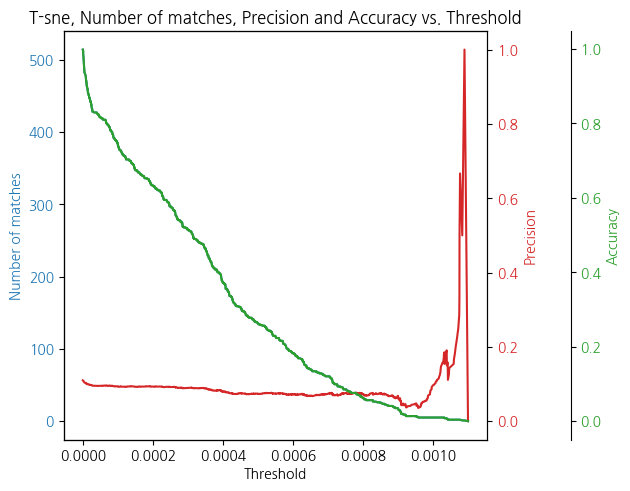

In [28]:
# Load the CSV files
abnormal_cases_df = pd.read_csv('abnormal_cases.csv')
data = df2

# Convert caseid in abnormal_cases to a set for fast lookup
abnormal_case_ids = set(abnormal_cases_df['0'])

# 매칭 수, 정밀도, 정확도를 계산하는 함수
def calculate_metrics(threshold, abnormal_case_ids, data):
    # 현재 임계값보다 leverage2가 큰 test_1의 caseid를 찾기
    test_case_ids = set(data[data['leverage1'] > threshold]['Case'])
    
    # 비정상 사례와의 매칭 수 계산
    matches = len(abnormal_case_ids.intersection(test_case_ids))
    
    # 정밀도 계산
    precision = matches / len(test_case_ids) if len(test_case_ids) > 0 else 0
    
    # 정확도 계산
    accuracy = matches / len(abnormal_case_ids) if len(abnormal_case_ids) > 0 else 0
    
    return matches, precision, accuracy

# 변수 초기화
thresholds = sorted(data['leverage1'].unique())
matches = []
precisions = []
accuracies = []

# 각 임계값에 대해 매칭 수, 정밀도, 정확도 계산
for threshold in thresholds:
    match, precision, accuracy = calculate_metrics(threshold, abnormal_case_ids, data)
    matches.append(match)
    precisions.append(precision)
    accuracies.append(accuracy)

# 매칭 수, 정밀도, 정확도 vs. 임계값 그래프
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Number of matches', color=color)
ax1.plot(thresholds, matches, color=color, label='Number of matches')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # 두 번째 y축을 공유하는 새로운 축
color = 'tab:red'
ax2.set_ylabel('Precision', color=color)
ax2.plot(thresholds, precisions, color=color, label='Precision')
ax2.tick_params(axis='y', labelcolor=color)

# 세 번째 축 추가하여 정확도 표시
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
color = 'tab:green'
ax3.set_ylabel('Accuracy', color=color)
ax3.plot(thresholds, accuracies, color=color, label='Accuracy')
ax3.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # 레이아웃 조정
plt.title('T-sne, Number of matches, Precision and Accuracy vs. Threshold')
plt.show()


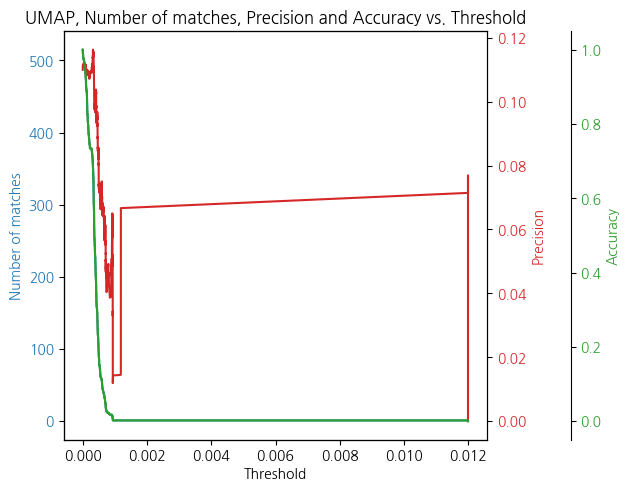

In [31]:
# Load the CSV files
abnormal_cases_df = pd.read_csv('abnormal_cases.csv')
data = df3

# Convert caseid in abnormal_cases to a set for fast lookup
abnormal_case_ids = set(abnormal_cases_df['0'])

# 매칭 수, 정밀도, 정확도를 계산하는 함수
def calculate_metrics(threshold, abnormal_case_ids, data):
    # 현재 임계값보다 leverage2가 큰 test_1의 caseid를 찾기
    test_case_ids = set(data[data['leverage1'] > threshold]['Case'])
    
    # 비정상 사례와의 매칭 수 계산
    matches = len(abnormal_case_ids.intersection(test_case_ids))
    
    # 정밀도 계산
    precision = matches / len(test_case_ids) if len(test_case_ids) > 0 else 0
    
    # 정확도 계산
    accuracy = matches / len(abnormal_case_ids) if len(abnormal_case_ids) > 0 else 0
    
    return matches, precision, accuracy

# 변수 초기화
thresholds = sorted(data['leverage1'].unique())
matches = []
precisions = []
accuracies = []

# 각 임계값에 대해 매칭 수, 정밀도, 정확도 계산
for threshold in thresholds:
    match, precision, accuracy = calculate_metrics(threshold, abnormal_case_ids, data)
    matches.append(match)
    precisions.append(precision)
    accuracies.append(accuracy)

# 매칭 수, 정밀도, 정확도 vs. 임계값 그래프
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Number of matches', color=color)
ax1.plot(thresholds, matches, color=color, label='Number of matches')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # 두 번째 y축을 공유하는 새로운 축
color = 'tab:red'
ax2.set_ylabel('Precision', color=color)
ax2.plot(thresholds, precisions, color=color, label='Precision')
ax2.tick_params(axis='y', labelcolor=color)

# 세 번째 축 추가하여 정확도 표시
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
color = 'tab:green'
ax3.set_ylabel('Accuracy', color=color)
ax3.plot(thresholds, accuracies, color=color, label='Accuracy')
ax3.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # 레이아웃 조정
plt.title('UMAP, Number of matches, Precision and Accuracy vs. Threshold')
plt.show()


In [2]:
# data[data['type_res_case'] != 'normal'] 에 해당하는 Case들을 반환

# Load the CSV files
abnormal_cases_df = pd.read_csv('abnormal_cases.csv')
test_1_df = pd.read_csv('result_table/test_1.csv')

# Convert caseid in abnormal_cases to a set for fast lookup
abnormal_case_ids = set(abnormal_cases_df['0'])

data = pd.read_csv('data/insert0.003_bpic2012_O_ACCEPTED-COMPLETE_clean.csv')

abnormal_cases = data[data['type_res_case'] != 'normal']['Case'].unique()

In [4]:
len(abnormal_cases)

515

In [5]:
# result1[result1['leverage2'] >= 0.2] 과 abnormal_cases의 일치하는 Case들을 반환
import pandas as pd

# Load the CSV files
abnormal_cases_df = pd.read_csv('abnormal_cases.csv')
test_1_df = pd.read_csv('result_table/test_1.csv')

# Convert caseid in abnormal_cases to a set for fast lookup
abnormal_case_ids = set(abnormal_cases_df['0'])

# Initialize variables to track the best threshold and the corresponding number of matches
best_threshold = None
max_matches = 0

# Iterate through possible thresholds
for threshold in sorted(test_1_df['leverage2'].unique()):
    # Find caseids in test_1 that have leverage2 greater than the current threshold
    test_case_ids = set(test_1_df[test_1_df['leverage2'] > threshold]['caseid'])
    
    # Calculate the number of matches with abnormal cases
    matches = len(abnormal_case_ids.intersection(test_case_ids))
    
    # Update the best threshold if the current one has more matches
    if matches > max_matches:
        best_threshold = threshold
        max_matches = matches

print(f'Best threshold: {best_threshold}')
print(f'Maximum matches: {max_matches}')


Best threshold: 2.4391251533293797e-12
Maximum matches: 514


In [51]:
test_1_df = pd.read_csv('result_table/test_1.csv')
len(test_1_df[test_1_df['leverage2'] > 0.067])

320

In [50]:
# thresoold가 0.2일 때, abnormal_cases와 test_1의 일치하는 Case들을 반환
matches = abnormal_case_ids.intersection(set(test_1_df[test_1_df['leverage2'] >= 0.067]['caseid']))
len(matches)

249

In [43]:
249/515

0.48349514563106794

In [52]:
249/320

0.778125

In [49]:
76/515

0.14757281553398058

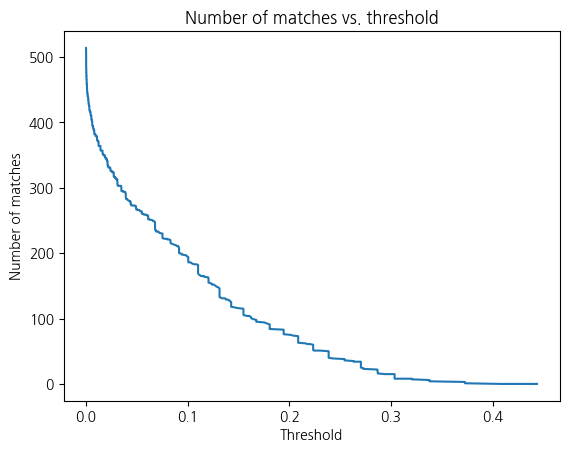

In [45]:
# threshold가 증가함에 따라 matches의 수를 계산하는 함수

def calculate_matches(threshold, abnormal_case_ids, test_1_df):
    # Find caseids in test_1 that have leverage2 greater than the current threshold
    test_case_ids = set(test_1_df[test_1_df['leverage2'] > threshold]['caseid'])
    
    # Calculate the number of matches with abnormal cases
    matches = len(abnormal_case_ids.intersection(test_case_ids))
    
    return matches

# 그래프

thresholds = sorted(test_1_df['leverage2'].unique())
matches = [calculate_matches(threshold, abnormal_case_ids, test_1_df) for threshold in thresholds]

plt.plot(thresholds, matches)
plt.xlabel('Threshold')
plt.ylabel('Number of matches')
plt.title('Number of matches vs. threshold')
plt.show()


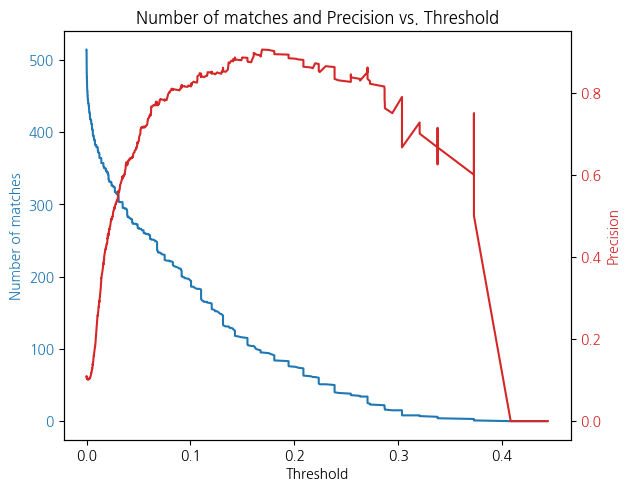

In [47]:
import matplotlib.pyplot as plt

# 매칭 수와 정밀도를 계산하는 함수
def calculate_matches_and_precision(threshold, abnormal_case_ids, test_1_df):
    # 현재 임계값보다 leverage2가 큰 test_1의 caseid를 찾기
    test_case_ids = set(test_1_df[test_1_df['leverage2'] > threshold]['caseid'])
    
    # 비정상 사례와의 매칭 수 계산
    matches = len(abnormal_case_ids.intersection(test_case_ids))
    
    # 정밀도 계산
    precision = matches / len(test_case_ids) if len(test_case_ids) > 0 else 0
    
    return matches, precision

# 변수 초기화
thresholds = sorted(test_1_df['leverage2'].unique())
matches = []
precisions = []

# 각 임계값에 대해 매칭 수와 정밀도 계산
for threshold in thresholds:
    match, precision = calculate_matches_and_precision(threshold, abnormal_case_ids, test_1_df)
    matches.append(match)
    precisions.append(precision)

# 매칭 수와 정밀도 vs. 임계값 그래프
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Number of matches', color=color)
ax1.plot(thresholds, matches, color=color, label='Number of matches')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # 두 번째 y축을 공유하는 새로운 축
color = 'tab:red'
ax2.set_ylabel('Precision', color=color)
ax2.plot(thresholds, precisions, color=color, label='Precision')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # 레이아웃 조정
plt.title('Number of matches and Precision vs. Threshold')
plt.show()


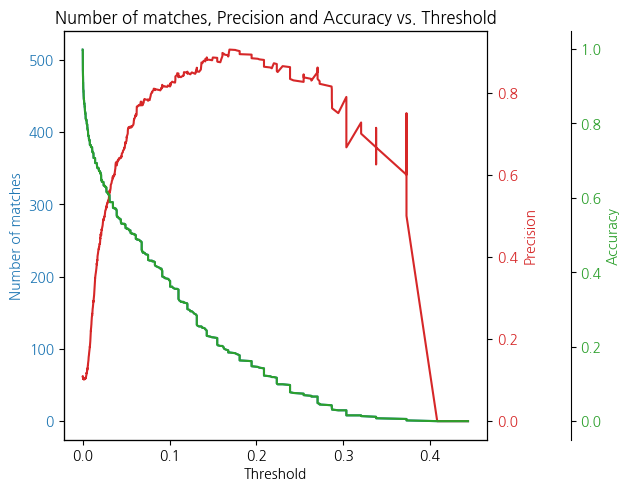

In [57]:
import matplotlib.pyplot as plt

# 매칭 수, 정밀도, 정확도를 계산하는 함수
def calculate_metrics(threshold, abnormal_case_ids, test_1_df):
    # 현재 임계값보다 leverage2가 큰 test_1의 caseid를 찾기
    test_case_ids = set(test_1_df[test_1_df['leverage2'] > threshold]['caseid'])
    
    # 비정상 사례와의 매칭 수 계산
    matches = len(abnormal_case_ids.intersection(test_case_ids))
    
    # 정밀도 계산
    precision = matches / len(test_case_ids) if len(test_case_ids) > 0 else 0
    
    # 정확도 계산
    accuracy = matches / len(abnormal_case_ids) if len(abnormal_case_ids) > 0 else 0
    
    return matches, precision, accuracy

# 변수 초기화
thresholds = sorted(test_1_df['leverage2'].unique())
matches = []
precisions = []
accuracies = []

# 각 임계값에 대해 매칭 수, 정밀도, 정확도 계산
for threshold in thresholds:
    match, precision, accuracy = calculate_metrics(threshold, abnormal_case_ids, test_1_df)
    matches.append(match)
    precisions.append(precision)
    accuracies.append(accuracy)

# 매칭 수, 정밀도, 정확도 vs. 임계값 그래프
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Number of matches', color=color)
ax1.plot(thresholds, matches, color=color, label='Number of matches')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # 두 번째 y축을 공유하는 새로운 축
color = 'tab:red'
ax2.set_ylabel('Precision', color=color)
ax2.plot(thresholds, precisions, color=color, label='Precision')
ax2.tick_params(axis='y', labelcolor=color)

# 세 번째 축 추가하여 정확도 표시
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
color = 'tab:green'
ax3.set_ylabel('Accuracy', color=color)
ax3.plot(thresholds, accuracies, color=color, label='Accuracy')
ax3.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # 레이아웃 조정
plt.title('Number of matches, Precision and Accuracy vs. Threshold')
plt.show()


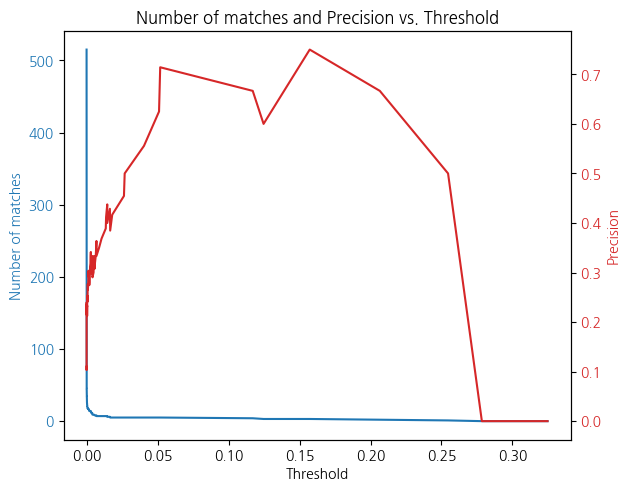

In [54]:
# 매칭 수와 정밀도를 계산하는 함수
def calculate_matches_and_precision(threshold, abnormal_case_ids, df):
    # 현재 임계값보다 leverage2가 큰 test_1의 caseid를 찾기
    test_case_ids = set(df[df['leverage2'] > threshold]['Case'])
    
    # 비정상 사례와의 매칭 수 계산
    matches = len(abnormal_case_ids.intersection(test_case_ids))
    
    # 정밀도 계산
    precision = matches / len(test_case_ids) if len(test_case_ids) > 0 else 0
    
    return matches, precision


df = pd.read_csv('result_table/result_pca_insert0.003_bpic2012_O_ACCEPTED-COMPLETE_clean.csv')

# 변수 초기화
thresholds = sorted(df['leverage2'].unique())
matches = []
precisions = []

# 각 임계값에 대해 매칭 수와 정밀도 계산
for threshold in thresholds:
    match, precision = calculate_matches_and_precision(threshold, abnormal_case_ids, df)
    matches.append(match)
    precisions.append(precision)

# 매칭 수와 정밀도 vs. 임계값 그래프
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Number of matches', color=color)
ax1.plot(thresholds, matches, color=color, label='Number of matches')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # 두 번째 y축을 공유하는 새로운 축
color = 'tab:red'
ax2.set_ylabel('Precision', color=color)
ax2.plot(thresholds, precisions, color=color, label='Precision')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # 레이아웃 조정
plt.title('Number of matches and Precision vs. Threshold')
plt.show()


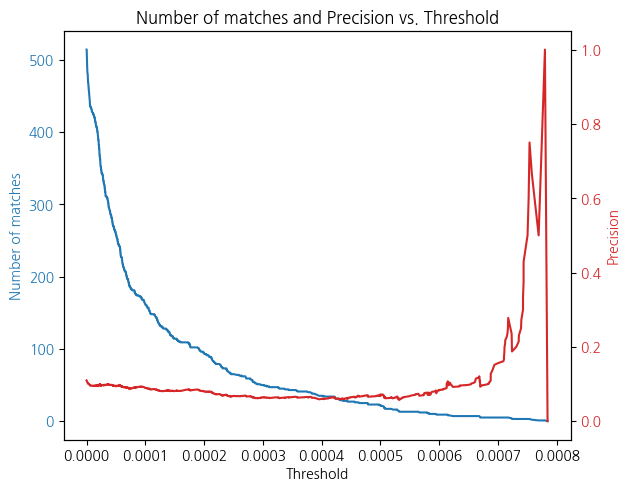

In [55]:
# 매칭 수와 정밀도를 계산하는 함수
def calculate_matches_and_precision(threshold, abnormal_case_ids, df):
    # 현재 임계값보다 leverage2가 큰 test_1의 caseid를 찾기
    test_case_ids = set(df[df['leverage2'] > threshold]['Case'])
    
    # 비정상 사례와의 매칭 수 계산
    matches = len(abnormal_case_ids.intersection(test_case_ids))
    
    # 정밀도 계산
    precision = matches / len(test_case_ids) if len(test_case_ids) > 0 else 0
    
    return matches, precision


df = pd.read_csv('result_table/result_tsne_insert0.003_bpic2012_O_ACCEPTED-COMPLETE_clean.csv')

# 변수 초기화
thresholds = sorted(df['leverage2'].unique())
matches = []
precisions = []

# 각 임계값에 대해 매칭 수와 정밀도 계산
for threshold in thresholds:
    match, precision = calculate_matches_and_precision(threshold, abnormal_case_ids, df)
    matches.append(match)
    precisions.append(precision)

# 매칭 수와 정밀도 vs. 임계값 그래프
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Number of matches', color=color)
ax1.plot(thresholds, matches, color=color, label='Number of matches')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # 두 번째 y축을 공유하는 새로운 축
color = 'tab:red'
ax2.set_ylabel('Precision', color=color)
ax2.plot(thresholds, precisions, color=color, label='Precision')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # 레이아웃 조정
plt.title('Number of matches and Precision vs. Threshold')
plt.show()


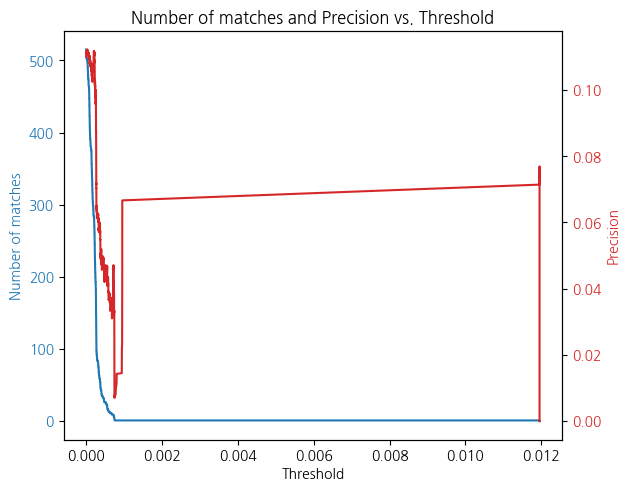

In [56]:
# 매칭 수와 정밀도를 계산하는 함수
def calculate_matches_and_precision(threshold, abnormal_case_ids, df):
    # 현재 임계값보다 leverage2가 큰 test_1의 caseid를 찾기
    test_case_ids = set(df[df['leverage2'] > threshold]['Case'])
    
    # 비정상 사례와의 매칭 수 계산
    matches = len(abnormal_case_ids.intersection(test_case_ids))
    
    # 정밀도 계산
    precision = matches / len(test_case_ids) if len(test_case_ids) > 0 else 0
    
    return matches, precision


df = pd.read_csv('result_table/result_umap_insert0.003_bpic2012_O_ACCEPTED-COMPLETE_clean.csv')

# 변수 초기화
thresholds = sorted(df['leverage2'].unique())
matches = []
precisions = []

# 각 임계값에 대해 매칭 수와 정밀도 계산
for threshold in thresholds:
    match, precision = calculate_matches_and_precision(threshold, abnormal_case_ids, df)
    matches.append(match)
    precisions.append(precision)

# 매칭 수와 정밀도 vs. 임계값 그래프
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Number of matches', color=color)
ax1.plot(thresholds, matches, color=color, label='Number of matches')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # 두 번째 y축을 공유하는 새로운 축
color = 'tab:red'
ax2.set_ylabel('Precision', color=color)
ax2.plot(thresholds, precisions, color=color, label='Precision')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # 레이아웃 조정
plt.title('Number of matches and Precision vs. Threshold')
plt.show()


In [44]:
# 이 알고리즘으로는 당연히 threshold가 낮을 수록 matching_cases의 값이 높아지겠지. matching_cases의 값은 최대한 높아져야 해.
# filtered_test_1_df의 개수는 최대한 낮아져야해.
# threshold의 최적 지점은 어디인가?

# Initialize lists to track thresholds and corresponding metrics
thresholds = []
metrics_list = []

# Iterate through possible thresholds
for threshold in np.arange(0, 1, 0.001):
    # Filter test_1_df based on the current threshold
    filtered_test_1_df = test_1_df[test_1_df['leverage2'] >= threshold]

    # Find matching cases between filtered_test_1_df and abnormal_cases_df
    matching_cases = filtered_test_1_df[filtered_test_1_df['caseid'].isin(abnormal_cases_df['caseid'])]
    
    # Record the threshold and metric
    thresholds.append(threshold)

# Find the threshold with the maximum metric
best_threshold = thresholds[metrics_list.index(max(metrics_list))]
max_metric = max(metrics_list)

# Plot the threshold vs. metric
plt.figure(figsize=(10, 6))
plt.plot(thresholds, metrics_list, marker='o')
plt.xlabel('Leverage2 Threshold')
plt.xlim(0, 0.5)
plt.ylabel('Matching Cases to Filtered Size Ratio (%)')
plt.title('Matching Cases to Filtered Size Ratio vs. Leverage2 Threshold')
plt.grid(True)
plt.show()

print(f'Best threshold: {best_threshold}')
print(f'Maximum ratio: {max_metric}')

ValueError: max() arg is an empty sequence

In [83]:
# threshold가 0.169일 때 matching_cases의 값은?

# Filter test_1_df based on the best threshold
filtered_test_1_df = test_1_df[test_1_df['leverage2'] >= best_threshold]

# Find matching cases between filtered_test_1_df and abnormal_cases_df
matching_cases = filtered_test_1_df[filtered_test_1_df['caseid'].isin(abnormal_cases_df['caseid'])]

len(matching_cases) / len(abnormal_cases_df['caseid']) * 100

18.446601941747574

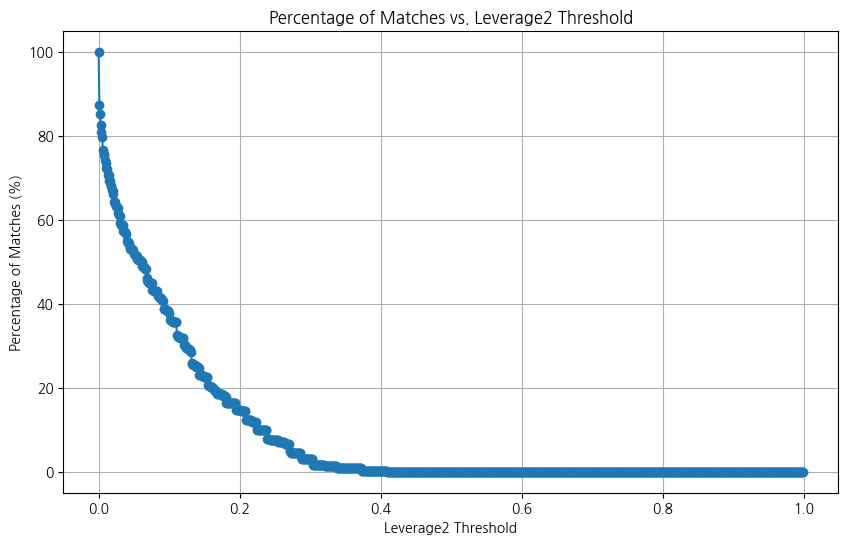

In [63]:
# threshold를 0.001 씩 증가시킨다.

그래프 2 
# Initialize lists to track thresholds and corresponding percentage of matches
thresholds = []
percentage_matches_list = []

# Iterate through possible thresholds
for threshold in np.arange(0, 1, 0.001):
    # Filter test_1_df based on the current threshold
    filtered_test_1_df = test_1_df[test_1_df['leverage2'] >= threshold]

    # Find matching cases between filtered_test_1_df and abnormal_cases_df
    matching_cases = filtered_test_1_df[filtered_test_1_df['caseid'].isin(abnormal_cases_df['caseid'])]

    # Calculate the percentage of matching cases
    percentage_matches = (len(matching_cases) / len(abnormal_cases_df['caseid'])) * 100

    # Record the threshold and percentage of matches
    thresholds.append(threshold)
    percentage_matches_list.append(percentage_matches)

# Plot the threshold vs. percentage of matches
plt.figure(figsize=(10, 6))
plt.plot(thresholds, percentage_matches_list, marker='o')
plt.xlabel('Leverage2 Threshold')
plt.ylabel('Percentage of Matches (%)')
plt.title('Percentage of Matches vs. Leverage2 Threshold')
plt.grid(True)
plt.show()

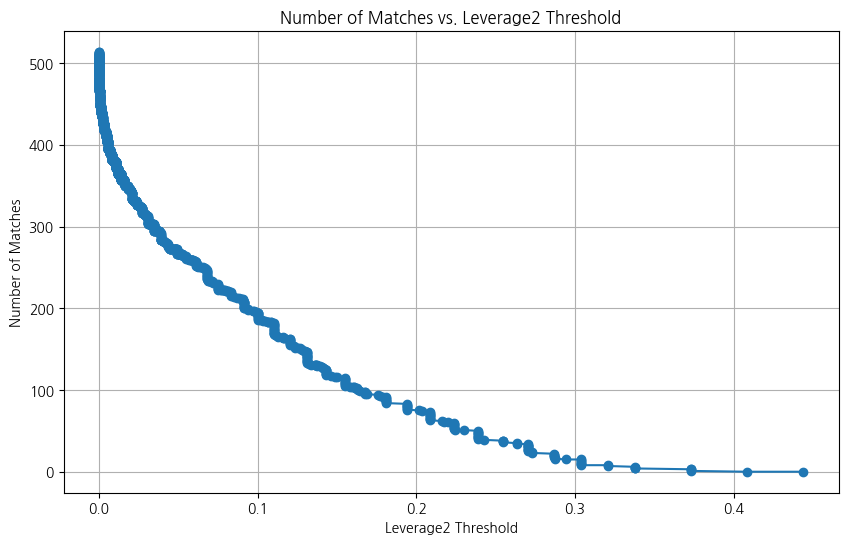

In [44]:
# threshold의 값에 따라 max_mathces의 값이 어떻게 변하는지 확인하는 그래프를 그리고 싶어
import pandas as pd
import matplotlib.pyplot as plt

# Initialize a list to track the threshold and corresponding number of matches
thresholds = []
matches_list = []

# Iterate through possible thresholds
for threshold in sorted(test_1_df['leverage2'].unique()):
    # Find caseids in test_1 that have leverage2 greater than the current threshold
    test_case_ids = set(test_1_df[test_1_df['leverage2'] > threshold]['caseid'])
    
    # Calculate the number of matches with abnormal cases
    matches = len(abnormal_case_ids.intersection(test_case_ids))
    
    # Record the threshold and number of matches
    thresholds.append(threshold)
    matches_list.append(matches)

# Plot the threshold vs. matches
plt.figure(figsize=(10, 6))
plt.plot(thresholds, matches_list, marker='o')
plt.xlabel('Leverage2 Threshold')
plt.ylabel('Number of Matches')
plt.title('Number of Matches vs. Leverage2 Threshold')
plt.grid(True)
plt.show()


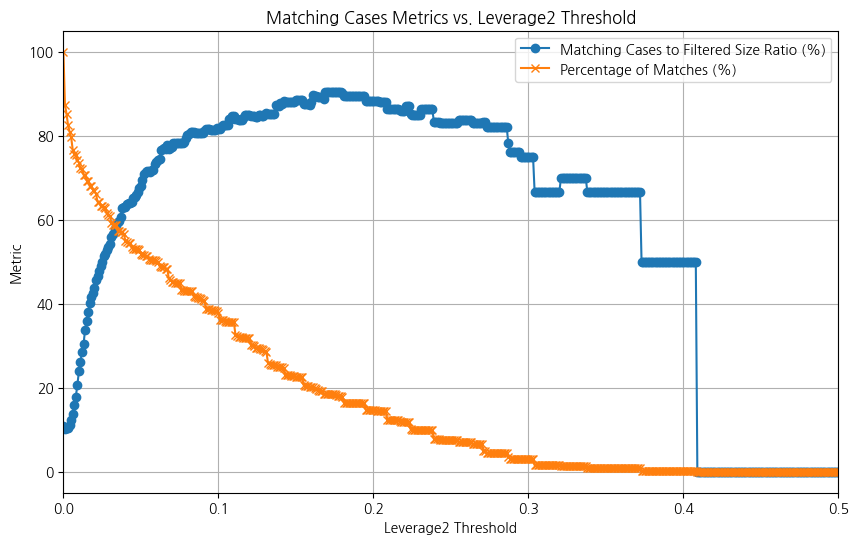

Best threshold: 0.067
Best metric value: 3762.1966019417473


In [84]:
# Initialize lists to track thresholds and corresponding metrics
thresholds = []
metrics_list = []
percentage_matches_list = []

# Define a function to calculate the metric
def calculate_metric(matching_cases, filtered_test_1_df):
    if len(filtered_test_1_df) == 0:
        return float('0')
    return (len(matching_cases) / len(filtered_test_1_df)) * 100

# Iterate through possible thresholds
for threshold in np.arange(0, 1, 0.001):
    # Filter test_1_df based on the current threshold
    filtered_test_1_df = test_1_df[test_1_df['leverage2'] >= threshold]

    # Find matching cases between filtered_test_1_df and abnormal_cases_df
    matching_cases = filtered_test_1_df[filtered_test_1_df['caseid'].isin(abnormal_cases_df['caseid'])]

    # Calculate the metric
    metric = calculate_metric(matching_cases, filtered_test_1_df)
    
    # Calculate the percentage of matching cases
    percentage_matches = (len(matching_cases) / len(abnormal_cases_df['caseid'])) * 100

    # Record the threshold, metric, and percentage of matches
    thresholds.append(threshold)
    metrics_list.append(metric)
    percentage_matches_list.append(percentage_matches)

# Plot the threshold vs. metric and percentage of matches
plt.figure(figsize=(10, 6))
plt.plot(thresholds, metrics_list, marker='o', label='Matching Cases to Filtered Size Ratio (%)')
plt.plot(thresholds, percentage_matches_list, marker='x', label='Percentage of Matches (%)')
plt.xlabel('Leverage2 Threshold')
plt.xlim(0, 0.5)
plt.ylabel('Metric')
plt.title('Matching Cases Metrics vs. Leverage2 Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Find the intersection point
best_threshold = thresholds[np.argmax(np.array(metrics_list) * np.array(percentage_matches_list))]
best_metric = max(np.array(metrics_list) * np.array(percentage_matches_list))

print(f'Best threshold: {best_threshold}')
print(f'Best metric value: {best_metric}')

In [86]:
# 0.02일 때 abnormal과 result의 이상치가 일치하는 비율은 20% 미만임.
# 0.067일 때 일치하는 비율은 60%에 가까우면서 matching_cases의 비율도 높음.

# 임계값 0.02:

# 이상치 일치 비율: 20% 미만
# matching_cases 비율: 낮음

# 임계값 0.067:

# 이상치 일치 비율: 60%에 가까움
# matching_cases 비율: 높음

AUC: -5654.126558990169


In [97]:
#test_1_df의 range가 어떻게 되지?

max(test_1_df['leverage2']), min(test_1_df['leverage2'])

(0.0007842000508777, 4.27313394861844e-08)

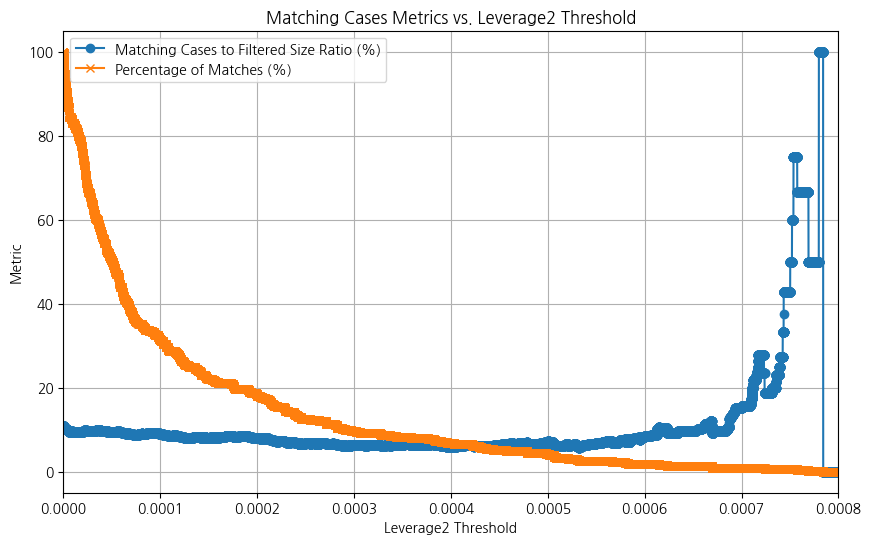

Best threshold: 0.0
Best metric value: 1099.2529348986127


In [101]:
# Load the CSV files
abnormal_cases_df = pd.read_csv('abnormal_cases.csv')
test_1_df = pd.read_csv('result_table/resulttsne_data.csv')

abnormal_cases_df.columns = ['caseid']
# Initialize lists to track thresholds and corresponding metrics
thresholds = []
metrics_list = []
percentage_matches_list = []

# Define a function to calculate the metric
def calculate_metric(matching_cases, filtered_test_1_df):
    if len(filtered_test_1_df) == 0:
        return float('0')
    return (len(matching_cases) / len(filtered_test_1_df)) * 100

# Iterate through possible thresholds
for threshold in np.arange(0, 0.0008, 1.00e-08):
    # Filter test_1_df based on the current threshold
    filtered_test_1_df = test_1_df[test_1_df['leverage2'] >= threshold]

    # Find matching cases between filtered_test_1_df and abnormal_cases_df
    matching_cases = filtered_test_1_df[filtered_test_1_df['Case'].isin(abnormal_cases_df['caseid'])]

    # Calculate the metric
    metric = calculate_metric(matching_cases, filtered_test_1_df)
    
    # Calculate the percentage of matching cases
    percentage_matches = (len(matching_cases) / len(abnormal_cases_df['caseid'])) * 100

    # Record the threshold, metric, and percentage of matches
    thresholds.append(threshold)
    metrics_list.append(metric)
    percentage_matches_list.append(percentage_matches)

# Plot the threshold vs. metric and percentage of matches
plt.figure(figsize=(10, 6))
plt.plot(thresholds, metrics_list, marker='o', label='Matching Cases to Filtered Size Ratio (%)')
plt.plot(thresholds, percentage_matches_list, marker='x', label='Percentage of Matches (%)')
plt.xlabel('Leverage2 Threshold')
plt.xlim(0, 0.0008)
plt.ylabel('Metric')
plt.title('Matching Cases Metrics vs. Leverage2 Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Find the intersection point
best_threshold = thresholds[np.argmax(np.array(metrics_list) * np.array(percentage_matches_list))]
best_metric = max(np.array(metrics_list) * np.array(percentage_matches_list))

print(f'Best threshold: {best_threshold}')
print(f'Best metric value: {best_metric}')

In [125]:
max(test_1_df['leverage2']), min(test_1_df['leverage2'])
# max(test_1_df['Dim2']), min(test_1_df['Dim2'])

(0.0119569289254058, 4.31843115151116e-07)

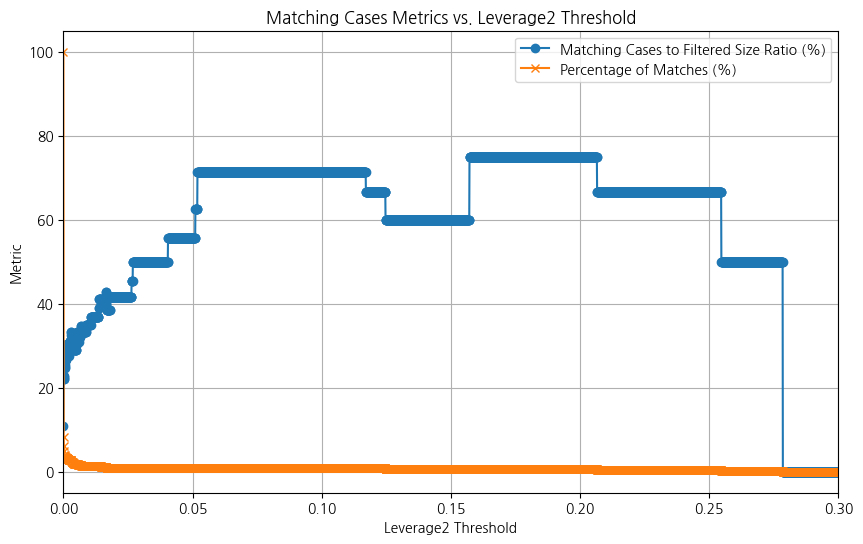

Best threshold: 0.0
Best metric value: 1099.2529348986127


In [142]:
# Load the CSV files
abnormal_cases_df = pd.read_csv('abnormal_cases.csv')
test_1_df = pd.read_csv('result_table/result_pca_insert0.003_bpic2012_O_ACCEPTED-COMPLETE_clean.csv')

abnormal_cases_df.columns = ['caseid']
# Initialize lists to track thresholds and corresponding metrics
thresholds = []
metrics_list = []
percentage_matches_list = []

# Define a function to calculate the metric
def calculate_metric(matching_cases, filtered_test_1_df):
    if len(filtered_test_1_df) == 0:
        return float('0')
    return (len(matching_cases) / len(filtered_test_1_df)) * 100

# Iterate through possible thresholds
for threshold in np.arange(0, 1, 0.0001):
    # Filter test_1_df based on the current threshold
    filtered_test_1_df = test_1_df[test_1_df['leverage2'] >= threshold]

    # Find matching cases between filtered_test_1_df and abnormal_cases_df
    matching_cases = filtered_test_1_df[filtered_test_1_df['Case'].isin(abnormal_cases_df['caseid'])]

    # Calculate the metric
    metric = calculate_metric(matching_cases, filtered_test_1_df)
    
    # Calculate the percentage of matching cases
    percentage_matches = (len(matching_cases) / len(abnormal_cases_df['caseid'])) * 100

    # Record the threshold, metric, and percentage of matches
    thresholds.append(threshold)
    metrics_list.append(metric)
    percentage_matches_list.append(percentage_matches)

# Plot the threshold vs. metric and percentage of matches
plt.figure(figsize=(10, 6))
plt.plot(thresholds, metrics_list, marker='o', label='Matching Cases to Filtered Size Ratio (%)')
plt.plot(thresholds, percentage_matches_list, marker='x', label='Percentage of Matches (%)')
plt.xlabel('Leverage2 Threshold')
plt.ylabel('Metric')
plt.title('Matching Cases Metrics vs. Leverage2 Threshold')
plt.legend()
plt.grid(True)
plt.xlim(0, 0.3)
plt.show()

# Find the intersection point
best_threshold = thresholds[np.argmax(np.array(metrics_list) * np.array(percentage_matches_list))]
best_metric = max(np.array(metrics_list) * np.array(percentage_matches_list))

print(f'Best threshold: {best_threshold}')
print(f'Best metric value: {best_metric}')

Best leverage1 threshold: 0.0
Best leverage2 threshold: 0.0
Best metric value: 10.992529348986126
Best percentage of matches: 100.0


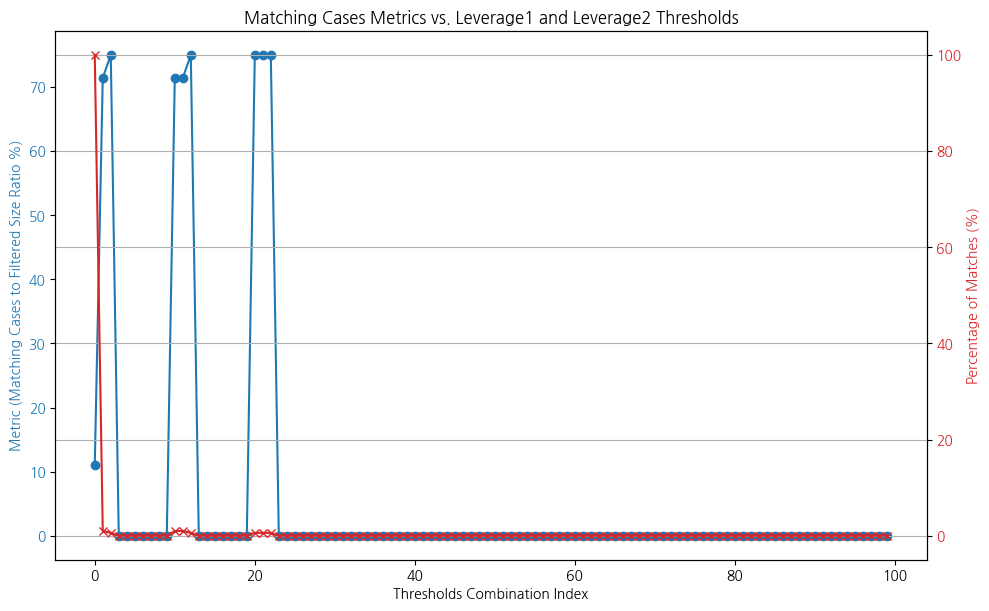

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV files
abnormal_cases_df = pd.read_csv('abnormal_cases.csv')
test_1_df = pd.read_csv('result_table/result_pca_insert0.003_bpic2012_O_ACCEPTED-COMPLETE_clean.csv')

abnormal_cases_df.columns = ['caseid']

# Initialize lists to track thresholds and corresponding metrics
thresholds_leverage1 = []
thresholds_leverage2 = []
metrics_list = []
percentage_matches_list = []

# Define a function to calculate the metric
def calculate_metric(matching_cases, filtered_test_1_df):
    if len(filtered_test_1_df) == 0:
        return float('0')
    return (len(matching_cases) / len(filtered_test_1_df)) * 100

# Iterate through possible thresholds
for threshold1 in np.arange(0, 1, 0.1):  # Adjust the step size as needed
    for threshold2 in np.arange(0, 1, 0.1):  # Adjust the step size as needed
        # Filter test_1_df based on the current thresholds
        filtered_test_1_df = test_1_df[(test_1_df['leverage1'] >= threshold1) & (test_1_df['leverage2'] >= threshold2)]

        # Find matching cases between filtered_test_1_df and abnormal_cases_df
        matching_cases = filtered_test_1_df[filtered_test_1_df['Case'].isin(abnormal_cases_df['caseid'])]

        # Calculate the metric
        metric = calculate_metric(matching_cases, filtered_test_1_df)
        
        # Calculate the percentage of matching cases
        percentage_matches = (len(matching_cases) / len(abnormal_cases_df['caseid'])) * 100

        # Record the thresholds, metric, and percentage of matches
        thresholds_leverage1.append(threshold1)
        thresholds_leverage2.append(threshold2)
        metrics_list.append(metric)
        percentage_matches_list.append(percentage_matches)

# Convert the lists to numpy arrays for easier manipulation
thresholds_leverage1 = np.array(thresholds_leverage1)
thresholds_leverage2 = np.array(thresholds_leverage2)
metrics_list = np.array(metrics_list)
percentage_matches_list = np.array(percentage_matches_list)

# Find the best combination of thresholds
best_index = np.argmax(metrics_list * percentage_matches_list)
best_threshold_leverage1 = thresholds_leverage1[best_index]
best_threshold_leverage2 = thresholds_leverage2[best_index]
best_metric = metrics_list[best_index]
best_percentage_matches = percentage_matches_list[best_index]

print(f'Best leverage1 threshold: {best_threshold_leverage1}')
print(f'Best leverage2 threshold: {best_threshold_leverage2}')
print(f'Best metric value: {best_metric}')
print(f'Best percentage of matches: {best_percentage_matches}')

# Plot the threshold vs. metric and percentage of matches
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Thresholds Combination Index')
ax1.set_ylabel('Metric (Matching Cases to Filtered Size Ratio %)', color=color)
ax1.plot(range(len(metrics_list)), metrics_list, marker='o', label='Matching Cases to Filtered Size Ratio (%)', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Percentage of Matches (%)', color=color)
ax2.plot(range(len(percentage_matches_list)), percentage_matches_list, marker='x', label='Percentage of Matches (%)', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Matching Cases Metrics vs. Leverage1 and Leverage2 Thresholds')
plt.grid(True)
plt.show()


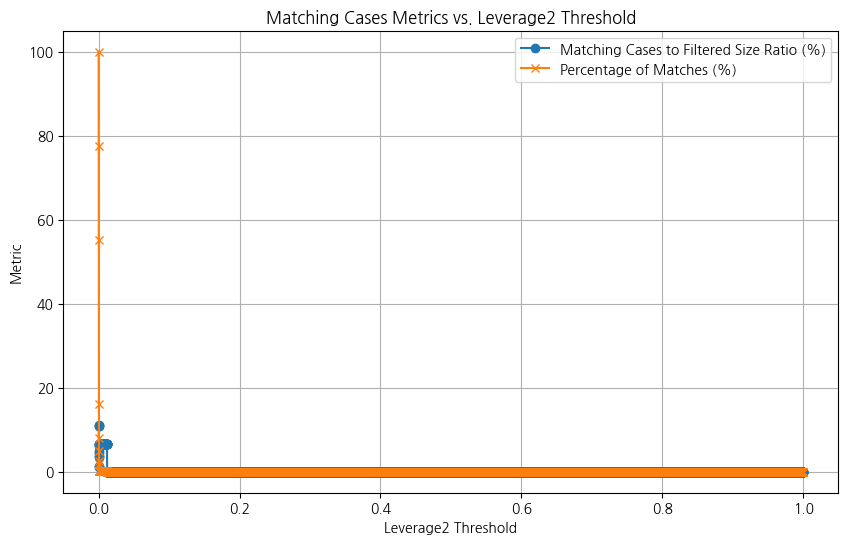

Best threshold: 0.0
Best metric value: 1099.2529348986127


In [16]:
# Load the CSV files
abnormal_cases_df = pd.read_csv('abnormal_cases.csv')
test_1_df = pd.read_csv('result_table/result_lle_insert0.003_bpic2012_O_ACCEPTED-COMPLETE_clean.csv')

abnormal_cases_df.columns = ['caseid']
# Initialize lists to track thresholds and corresponding metrics
thresholds = []
metrics_list = []
percentage_matches_list = []

# Define a function to calculate the metric
def calculate_metric(matching_cases, filtered_test_1_df):
    if len(filtered_test_1_df) == 0:
        return float('0')
    return (len(matching_cases) / len(filtered_test_1_df)) * 100

# Iterate through possible thresholds
for threshold in np.arange(0, 1, 0.0001):
    # Filter test_1_df based on the current threshold
    filtered_test_1_df = test_1_df[test_1_df['leverage2'] >= threshold]

    # Find matching cases between filtered_test_1_df and abnormal_cases_df
    matching_cases = filtered_test_1_df[filtered_test_1_df['Case'].isin(abnormal_cases_df['caseid'])]

    # Calculate the metric
    metric = calculate_metric(matching_cases, filtered_test_1_df)
    
    # Calculate the percentage of matching cases
    percentage_matches = (len(matching_cases) / len(abnormal_cases_df['caseid'])) * 100

    # Record the threshold, metric, and percentage of matches
    thresholds.append(threshold)
    metrics_list.append(metric)
    percentage_matches_list.append(percentage_matches)

# Plot the threshold vs. metric and percentage of matches
plt.figure(figsize=(10, 6))
plt.plot(thresholds, metrics_list, marker='o', label='Matching Cases to Filtered Size Ratio (%)')
plt.plot(thresholds, percentage_matches_list, marker='x', label='Percentage of Matches (%)')
plt.xlabel('Leverage2 Threshold')
plt.ylabel('Metric')
plt.title('Matching Cases Metrics vs. Leverage2 Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Find the intersection point
best_threshold = thresholds[np.argmax(np.array(metrics_list) * np.array(percentage_matches_list))]
best_metric = max(np.array(metrics_list) * np.array(percentage_matches_list))

print(f'Best threshold: {best_threshold}')
print(f'Best metric value: {best_metric}')

Test - Optimal Threshold: 0.052550806523631, Max F1 Score: 0.5997745208568207


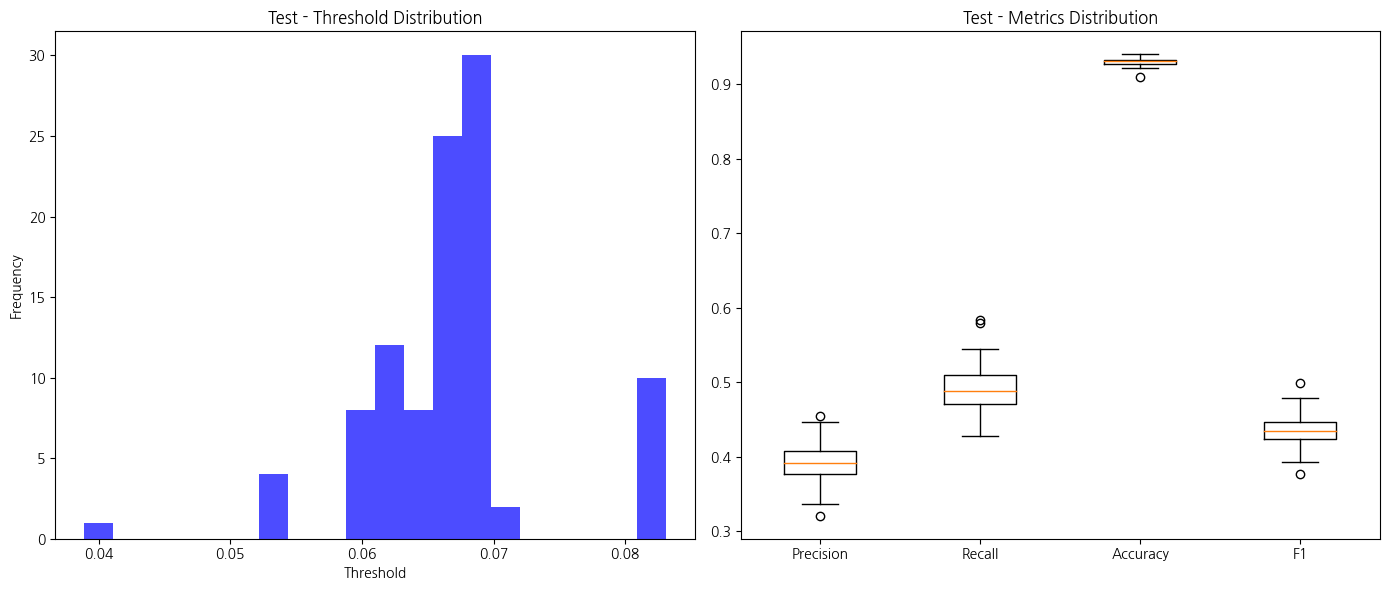

PCA - Optimal Threshold: 1.04326886463951e-05, Max F1 Score: 0.20057859209257475


c:\Temp\ipykernel_17932\2164638915.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
C:\Users\yeon1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


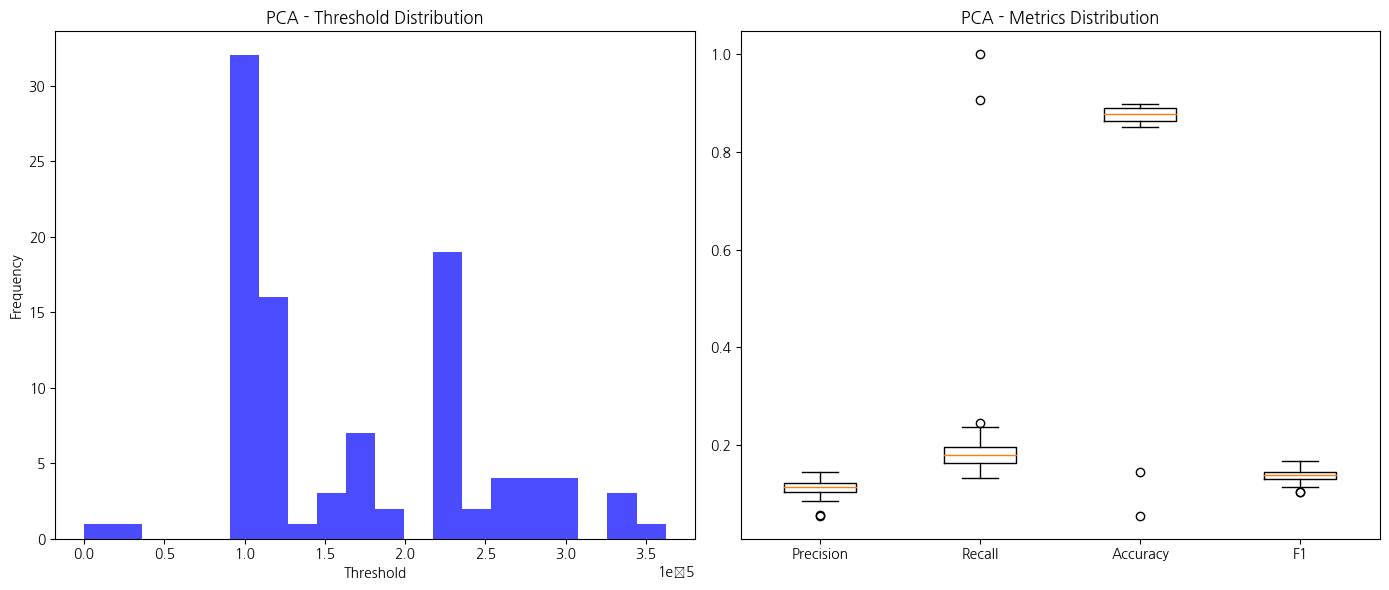

TSNE - Optimal Threshold: 4.27313394861844e-08, Max F1 Score: 0.19773033275629925


c:\Temp\ipykernel_17932\2164638915.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
C:\Users\yeon1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


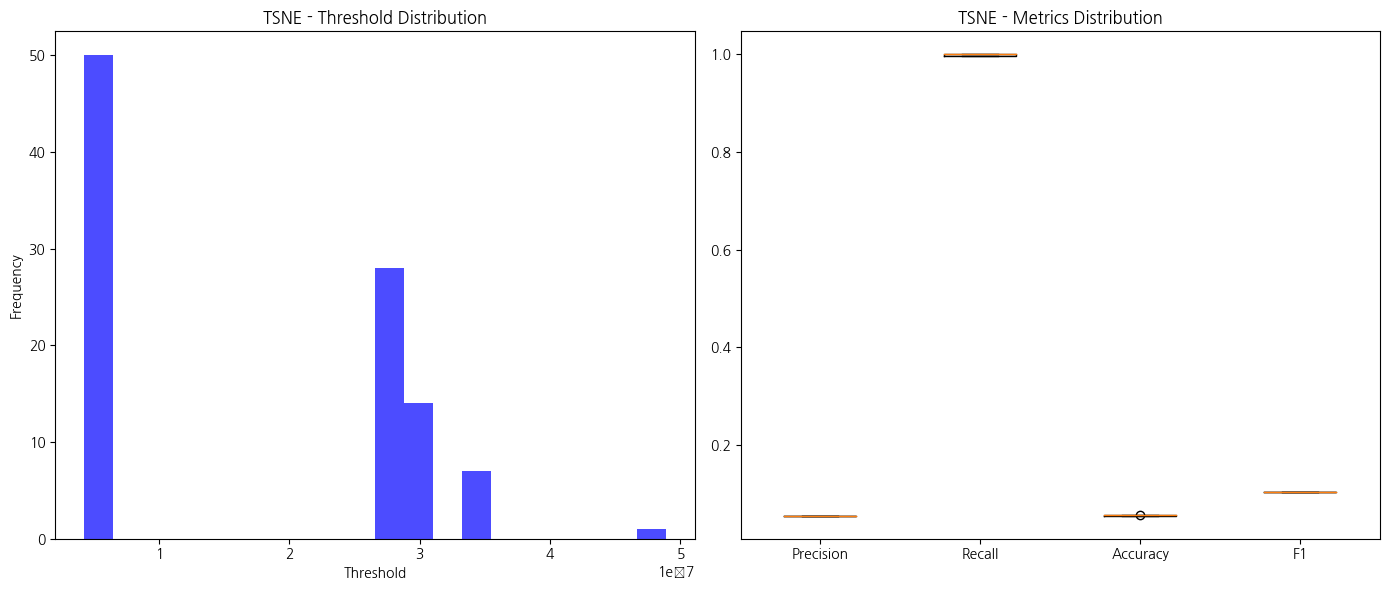

UMAP - Optimal Threshold: 2.2745310432561e-05, Max F1 Score: 0.20120481927710845


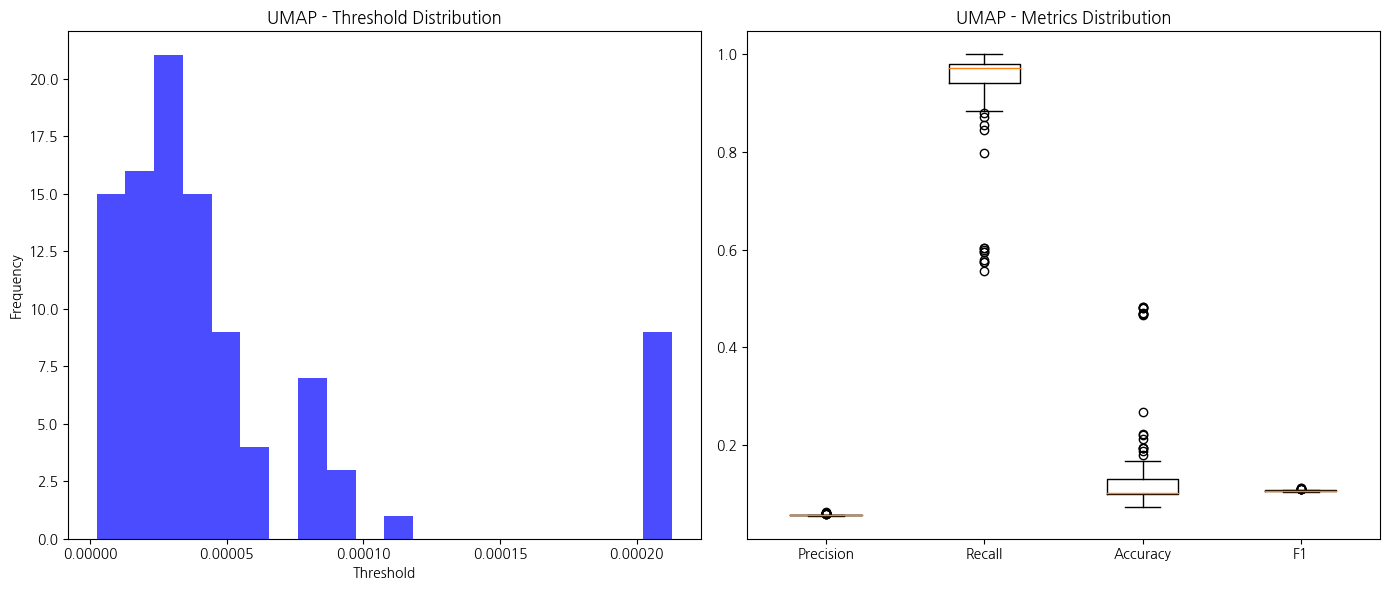

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# 데이터셋 로드
data_files = {
    'Test': 'result_table/test_1.csv',
    'PCA': 'result_table/result_pca_insert0.003_bpic2012_O_ACCEPTED-COMPLETE_clean.csv',
    'TSNE': 'result_table/result_tsne_insert0.003_bpic2012_O_ACCEPTED-COMPLETE_clean.csv',
    'UMAP': 'result_table/result_umap_insert0.003_bpic2012_O_ACCEPTED-COMPLETE_clean.csv'
}

abnormal_cases_df = pd.read_csv('abnormal_cases.csv')
abnormal_case_ids = set(abnormal_cases_df['0'])

def calculate_metrics(threshold, abnormal_case_ids, data, leverage_col='leverage2'):
    try: test_case_ids = set(data[data[leverage_col] > threshold]['Case'])
    except: test_case_ids = set(data[data[leverage_col] > threshold]['caseid'])
    matches = len(abnormal_case_ids.intersection(test_case_ids))
    
    TP = matches
    FP = len(test_case_ids) - matches
    FN = len(abnormal_case_ids) - matches
    TN = len(data) - (TP + FP + FN)
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, accuracy, f1

def find_optimal_threshold(data, abnormal_case_ids, leverage_col='leverage2'):
    thresholds = sorted(data[leverage_col].unique())
    f1_scores = []
    
    for threshold in thresholds:
        _, _, _, f1 = calculate_metrics(threshold, abnormal_case_ids, data, leverage_col)
        f1_scores.append(f1)
    
    max_f1 = max(f1_scores)
    optimal_threshold = thresholds[f1_scores.index(max_f1)] if max_f1 > 0 else thresholds[0]
    
    return optimal_threshold, max_f1

def simulate_experiment(data, abnormal_case_ids, iterations=100, leverage_col='leverage2'):
    results = {'threshold': [], 'precision': [], 'recall': [], 'accuracy': [], 'f1': []}
    np.random.seed(42)
    
    for _ in range(iterations):
        sample_abnormal_ids = set(np.random.choice(list(abnormal_case_ids), size=len(abnormal_case_ids)//2, replace=False))
        threshold, max_f1 = find_optimal_threshold(data, sample_abnormal_ids, leverage_col)
        
        precision, recall, accuracy, f1 = calculate_metrics(threshold, sample_abnormal_ids, data, leverage_col)
        
        results['threshold'].append(threshold)
        results['precision'].append(precision)
        results['recall'].append(recall)
        results['accuracy'].append(accuracy)
        results['f1'].append(f1)
    
    return pd.DataFrame(results)

# 각 데이터셋 분석
for name, file_path in data_files.items():
    data = pd.read_csv(file_path)
    optimal_threshold, max_f1 = find_optimal_threshold(data, abnormal_case_ids)
    cleaned_data = data[data['leverage2'] <= optimal_threshold]
    
    # 클린된 데이터 저장
    # cleaned_data.to_csv(f'cleaned_data_{name}.csv', index=False)
    
    # 결과 출력 및 그래프
    print(f'{name} - Optimal Threshold: {optimal_threshold}, Max F1 Score: {max_f1}')
    
    # 시뮬레이션
    simulation_results = simulate_experiment(data, abnormal_case_ids)
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    ax[0].hist(simulation_results['threshold'], bins=20, color='blue', alpha=0.7)
    ax[0].set_title(f'{name} - Threshold Distribution')
    ax[0].set_xlabel('Threshold')
    ax[0].set_ylabel('Frequency')
    
    ax[1].boxplot([simulation_results['precision'], simulation_results['recall'], simulation_results['accuracy'], simulation_results['f1']], labels=['Precision', 'Recall', 'Accuracy', 'F1'])
    ax[1].set_title(f'{name} - Metrics Distribution')
    
    plt.tight_layout()
    plt.show()


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# 데이터셋 로드
data_files = {
    'Test': 'result_table/test_1.csv',
    'PCA': 'result_table/result_pca_insert0.003_bpic2012_O_ACCEPTED-COMPLETE_clean.csv',
    'TSNE': 'result_table/result_tsne_insert0.003_bpic2012_O_ACCEPTED-COMPLETE_clean.csv',
    'UMAP': 'result_table/result_umap_insert0.003_bpic2012_O_ACCEPTED-COMPLETE_clean.csv'
}

abnormal_cases_df = pd.read_csv('abnormal_cases.csv')
abnormal_case_ids = set(abnormal_cases_df['0'])

def calculate_metrics(threshold, abnormal_case_ids, data, leverage_col='leverage2'):
    try: test_case_ids = set(data[data[leverage_col] > threshold]['Case'])
    except: test_case_ids = set(data[data[leverage_col] > threshold]['caseid'])
    matches = len(abnormal_case_ids.intersection(test_case_ids))
    
    TP = matches
    FP = len(test_case_ids) - matches
    FN = len(abnormal_case_ids) - matches
    TN = len(data) - (TP + FP + FN)
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, accuracy, f1

# find wanted threshold (high, medium, low)
def find_wanted_threshold(data, abnormal_case_ids, leverage_col='leverage2', wanted=('high', 'medium', 'low')):
    # wanted = ['high', 'medium', 'low']
    thresholds = sorted(data[leverage_col].unique())
    f1_scores = []

    for threshold in thresholds:
        if wanted == 'high':
            _, _, _, f1 = calculate_metrics(threshold, abnormal_case_ids, data, leverage_col)
            f1_scores.append(f1)
        elif wanted == 'medium':
            _, _, _, f1 = calculate_metrics(threshold, abnormal_case_ids, data, leverage_col)/3*2
            f1_scores.append(f1)
        elif wanted == 'low':
            _, _, _, f1 = calculate_metrics(threshold, abnormal_case_ids, data, leverage_col)/3
            f1_scores.append(f1)
        return f1_scores
    
    max_f1 = max(f1_scores)

    optimal_threshold = thresholds[f1_scores.index(max_f1)] if max_f1 > 0 else thresholds[0]
    return optimal_threshold, max_f1


def find_optimal_threshold(data, abnormal_case_ids, leverage_col='leverage2'):
    thresholds = sorted(data[leverage_col].unique())
    
    for threshold in thresholds:
        _, _, _, f1 = calculate_metrics(threshold, abnormal_case_ids, data, leverage_col)
        f1_scores.append(f1)
    
    max_f1 = max(f1_scores)
    optimal_threshold = thresholds[f1_scores.index(max_f1)] if max_f1 > 0 else thresholds[0]
    
    return optimal_threshold, max_f1

def simulate_experiment(data, abnormal_case_ids, iterations=100, leverage_col='leverage2'):
    results = {'threshold': [], 'precision': [], 'recall': [], 'accuracy': [], 'f1': []}
    np.random.seed(42)
    
    for _ in range(iterations):
        sample_abnormal_ids = set(np.random.choice(list(abnormal_case_ids), size=len(abnormal_case_ids)//2, replace=False))
        threshold, max_f1 = find_wanted_threshold(data, sample_abnormal_ids, leverage_col, wanted='high')
        
        precision, recall, accuracy, f1 = calculate_metrics(threshold, sample_abnormal_ids, data, leverage_col)
        
        results['threshold'].append(threshold)
        results['precision'].append(precision)
        results['recall'].append(recall)
        results['accuracy'].append(accuracy)
        results['f1'].append(f1)
    
    return pd.DataFrame(results)

# 각 데이터셋 분석
for name, file_path in data_files.items():
    data = pd.read_csv(file_path)
    optimal_threshold, max_f1 = find_wanted_threshold(data, abnormal_case_ids, leverage_col='leverage2', wanted='high')
    cleaned_data = data[data['leverage2'] <= optimal_threshold]
    
    # 클린된 데이터 저장
    # cleaned_data.to_csv(f'cleaned_data_{name}.csv', index=False)
    
    # 결과 출력 및 그래프
    print(f'{name} - Optimal Threshold: {optimal_threshold}, Max F1 Score: {max_f1}')
    
    # 시뮬레이션
    simulation_results = simulate_experiment(data, abnormal_case_ids)
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    ax[0].hist(simulation_results['threshold'], bins=20, color='blue', alpha=0.7)
    ax[0].set_title(f'{name} - Threshold Distribution')
    ax[0].set_xlabel('Threshold')
    ax[0].set_ylabel('Frequency')
    
    ax[1].boxplot([simulation_results['precision'], simulation_results['recall'], simulation_results['accuracy'], simulation_results['f1']], labels=['Precision', 'Recall', 'Accuracy', 'F1'])
    ax[1].set_title(f'{name} - Metrics Distribution')
    
    # plt.tight_layout()
    # plt.show()


ValueError: not enough values to unpack (expected 2, got 1)

C:\Users\yeon1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yeon1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yeon1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill

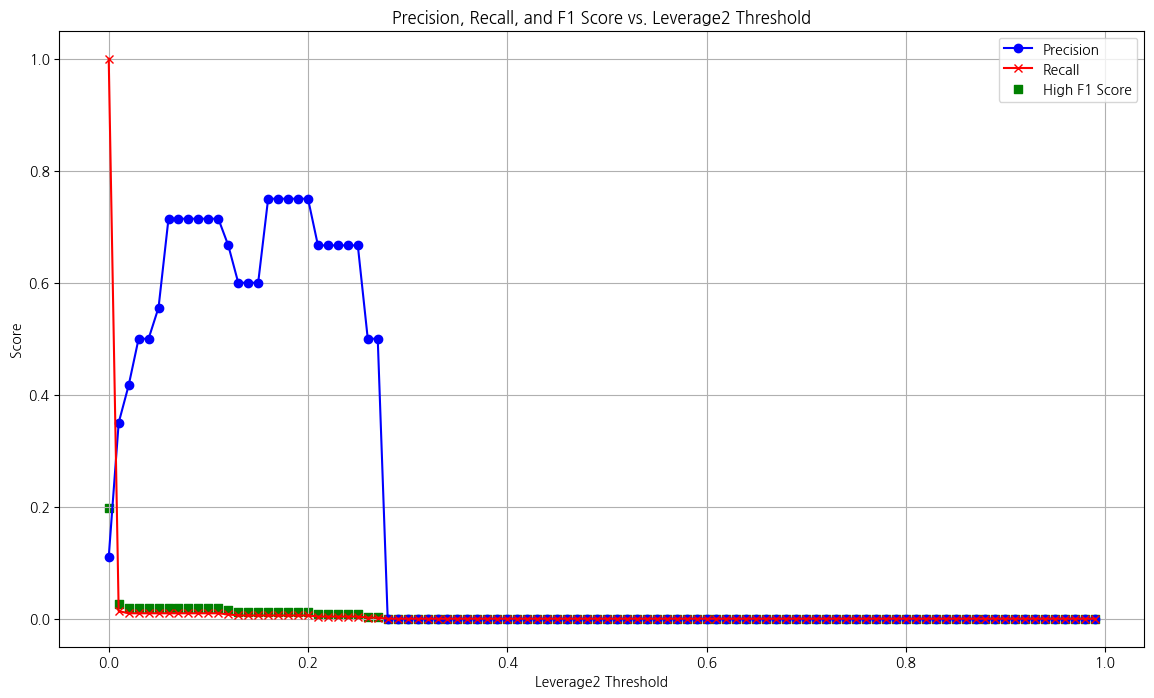

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# CSV 파일 로드
abnormal_cases_df = pd.read_csv('abnormal_cases.csv')
data = pd.read_csv('result_table/result_pca_insert0.003_bpic2012_O_ACCEPTED-COMPLETE_clean.csv')

# abnormal_cases_df의 컬럼 이름 변경
abnormal_cases_df.columns = ['Case']

# data와 abnormal_cases_df 간의 일치하는 케이스 찾기
data['Anomaly'] = data['Case'].isin(abnormal_cases_df['Case']).map({True: 'Anomaly', False: 'Normal'})

# 임계값 범위 설정
thresholds = np.arange(0.0, 1.0, 0.01)

# Precision, Recall, F1 Score를 저장할 리스트 초기화
precisions = []
recalls = []
f1_scores = []

# 각 임계값에 대해 Precision, Recall, F1 Score 계산
for threshold in thresholds:
    data['Prediction'] = data['leverage2'].apply(lambda x: 'Anomaly' if x > threshold else 'Normal')
    
    precision = precision_score(data['Anomaly'], data['Prediction'], pos_label='Anomaly')
    recall = recall_score(data['Anomaly'], data['Prediction'], pos_label='Anomaly')
    f1 = f1_score(data['Anomaly'], data['Prediction'], pos_label='Anomaly')
    
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# F1 Score 분포를 기준으로 Low, Medium, High 구간 설정
low_threshold = np.percentile(f1_scores, 33)
high_threshold = np.percentile(f1_scores, 66)

# 그래프 그리기
plt.figure(figsize=(14, 8))
plt.plot(thresholds, precisions, label='Precision', marker='o', color='blue')
plt.plot(thresholds, recalls, label='Recall', marker='x', color='red')

# F1 Score 라벨링 및 표시
for i, (threshold, f1) in enumerate(zip(thresholds, f1_scores)):
    if f1 < low_threshold:
        plt.scatter(threshold, f1, color='red', marker='o', label='Low F1 Score' if i == 0 else "")
    elif f1 < high_threshold:
        plt.scatter(threshold, f1, color='yellow', marker='x', label='Medium F1 Score' if i == 0 else "")
    else:
        plt.scatter(threshold, f1, color='green', marker='s', label='High F1 Score' if i == 0 else "")

plt.xlabel('Leverage2 Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Leverage2 Threshold')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.grid(True)
plt.show()


In [10]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# CSV 파일 로드
abnormal_cases_df = pd.read_csv('abnormal_cases.csv')
data = pd.read_csv('result_table/result_pca_insert0.003_bpic2012_O_ACCEPTED-COMPLETE_clean.csv')

# abnormal_cases_df의 컬럼 이름 변경
abnormal_cases_df.columns = ['Case']

# data와 abnormal_cases_df 간의 일치하는 케이스 찾기
data['Anomaly'] = data['Case'].isin(abnormal_cases_df['Case']).map({True: 'Anomaly', False: 'Normal'})

# 임계값 범위 설정
thresholds = np.arange(0.0, 1.0, 0.01)

# Precision, Recall, F1 Score를 저장할 리스트 초기화
precisions = []
recalls = []
f1_scores = []

# 각 임계값에 대해 Precision, Recall, F1 Score 계산
for threshold in thresholds:
    data['Prediction'] = data['leverage2'].apply(lambda x: 'Anomaly' if x > threshold else 'Normal')
    
    precision = precision_score(data['Anomaly'], data['Prediction'], pos_label='Anomaly')
    recall = recall_score(data['Anomaly'], data['Prediction'], pos_label='Anomaly')
    f1 = f1_score(data['Anomaly'], data['Prediction'], pos_label='Anomaly')
    
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# F1 Score 분포를 기준으로 Low, Medium, High 구간 설정
low_threshold = np.percentile(f1_scores, 33)
high_threshold = np.percentile(f1_scores, 66)

# 각 구간에 해당하는 임계값과 F1 Score 출력
low_f1_scores = [(thresholds[i], f1) for i, f1 in enumerate(f1_scores) if f1 < low_threshold]
medium_f1_scores = [(thresholds[i], f1) for i, f1 in enumerate(f1_scores) if low_threshold <= f1 < high_threshold]
high_f1_scores = [(thresholds[i], f1) for i, f1 in enumerate(f1_scores) if f1 >= high_threshold]

print("Low F1 Scores and Corresponding Thresholds:")
for threshold, f1 in low_f1_scores:
    print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.2f}")

print("\nMedium F1 Scores and Corresponding Thresholds:")
for threshold, f1 in medium_f1_scores:
    print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.2f}")

print("\nHigh F1 Scores and Corresponding Thresholds:")
for threshold, f1 in high_f1_scores:
    print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.2f}")


C:\Users\yeon1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yeon1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yeon1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill

Low F1 Scores and Corresponding Thresholds:

Medium F1 Scores and Corresponding Thresholds:

High F1 Scores and Corresponding Thresholds:
Threshold: 0.00, F1 Score: 0.20
Threshold: 0.01, F1 Score: 0.03
Threshold: 0.02, F1 Score: 0.02
Threshold: 0.03, F1 Score: 0.02
Threshold: 0.04, F1 Score: 0.02
Threshold: 0.05, F1 Score: 0.02
Threshold: 0.06, F1 Score: 0.02
Threshold: 0.07, F1 Score: 0.02
Threshold: 0.08, F1 Score: 0.02
Threshold: 0.09, F1 Score: 0.02
Threshold: 0.10, F1 Score: 0.02
Threshold: 0.11, F1 Score: 0.02
Threshold: 0.12, F1 Score: 0.02
Threshold: 0.13, F1 Score: 0.01
Threshold: 0.14, F1 Score: 0.01
Threshold: 0.15, F1 Score: 0.01
Threshold: 0.16, F1 Score: 0.01
Threshold: 0.17, F1 Score: 0.01
Threshold: 0.18, F1 Score: 0.01
Threshold: 0.19, F1 Score: 0.01
Threshold: 0.20, F1 Score: 0.01
Threshold: 0.21, F1 Score: 0.01
Threshold: 0.22, F1 Score: 0.01
Threshold: 0.23, F1 Score: 0.01
Threshold: 0.24, F1 Score: 0.01
Threshold: 0.25, F1 Score: 0.01
Threshold: 0.26, F1 Score: 0.0

C:\Users\yeon1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yeon1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# CSV 파일 로드
abnormal_cases_df = pd.read_csv('abnormal_cases.csv')
data = pd.read_csv('result_table/result_pca_insert0.003_bpic2012_O_ACCEPTED-COMPLETE_clean.csv')

# abnormal_cases_df의 컬럼 이름 변경
abnormal_cases_df.columns = ['Case']

# data와 abnormal_cases_df 간의 일치하는 케이스 찾기
data['Anomaly'] = data['Case'].isin(abnormal_cases_df['Case']).map({True: 'Anomaly', False: 'Normal'})

# 무작위로 data['Prediction'] 값을 변경
np.random.seed(42)  # 재현성을 위해 시드 고정
data['Prediction'] = np.random.choice(['Anomaly', 'Normal'], size=len(data))

# Precision, Recall, F1 Score 계산
precision = precision_score(data['Anomaly'], data['Prediction'], pos_label='Anomaly')
recall = recall_score(data['Anomaly'], data['Prediction'], pos_label='Anomaly')
f1 = f1_score(data['Anomaly'], data['Prediction'], pos_label='Anomaly')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


Precision: 0.12
Recall: 0.52
F1 Score: 0.19


In [27]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# CSV 파일 로드
abnormal_cases_df = pd.read_csv('abnormal_cases.csv')
data = pd.read_csv('result_table/result_tsne_insert0.003_bpic2012_O_ACCEPTED-COMPLETE_clean.csv')

# abnormal_cases_df의 컬럼 이름 변경
abnormal_cases_df.columns = ['Case']

# data와 abnormal_cases_df 간의 일치하는 케이스 찾기
data['Anomaly'] = data['Case'].isin(abnormal_cases_df['Case']).map({True: 'Anomaly', False: 'Normal'})

# F1 점수를 저장할 리스트 초기화
f1_scores = []

# 무작위로 100번 실행하여 F1 점수 계산
for _ in range(100):
    np.random.seed()  # 시드를 매번 다르게 설정
    data['Prediction'] = np.random.choice(['Anomaly', 'Normal'], size=len(data))
    
    precision = precision_score(data['Anomaly'], data['Prediction'], pos_label='Anomaly')
    recall = recall_score(data['Anomaly'], data['Prediction'], pos_label='Anomaly')
    f1 = f1_score(data['Anomaly'], data['Prediction'], pos_label='Anomaly')
    
    f1_scores.append(f1)

# F1 점수 분포를 기준으로 Low, Medium, High 구간 설정
f1_scores = np.array(f1_scores)
low_threshold = np.percentile(f1_scores, 33)
high_threshold = np.percentile(f1_scores, 66)

# 각 구간에 해당하는 F1 점수 출력
low_f1_scores = f1_scores[f1_scores < low_threshold]
medium_f1_scores = f1_scores[(f1_scores >= low_threshold) & (f1_scores < high_threshold)]
high_f1_scores = f1_scores[f1_scores >= high_threshold]

print(f"Low F1 Scores: {low_f1_scores}")
print(f"Low F1 Score Threshold: < {low_threshold:.2f}\n")

print(f"Medium F1 Scores: {medium_f1_scores}")
print(f"Medium F1 Score Threshold: {low_threshold:.2f} - {high_threshold:.2f}\n")

print(f"High F1 Scores: {high_f1_scores}")
print(f"High F1 Score Threshold: >= {high_threshold:.2f}")


Low F1 Scores: [0.16813225 0.1661496  0.17298415 0.16336634 0.16511127 0.17171006
 0.17583939 0.17412935 0.1754386  0.1720354  0.17532918 0.16835487
 0.17493113 0.17537706 0.16345142 0.17038818 0.17311103 0.17148832
 0.17295374 0.1759388  0.17240181 0.17487856 0.17427101 0.17140898
 0.17196784 0.17073171 0.16828929 0.17422096 0.16469771 0.16964599
 0.17507942 0.16637168 0.17403608]
Low F1 Score Threshold: < 0.18

Medium F1 Scores: [0.18250171 0.17981521 0.17704011 0.17630264 0.18207581 0.18050293
 0.17760618 0.17744154 0.18010471 0.18066784 0.18111888 0.17630662
 0.18099231 0.18044077 0.1773913  0.1802935  0.17630854 0.18005041
 0.18345324 0.17857143 0.17916667 0.18112156 0.18038948 0.18283713
 0.17634409 0.18049793 0.17618041 0.18343406 0.18016123 0.1765928
 0.17945109 0.17746967 0.18277311]
Medium F1 Score Threshold: 0.18 - 0.18

High F1 Scores: [0.19624217 0.19546248 0.18536585 0.19274611 0.19168428 0.18657487
 0.18421967 0.18898187 0.19629759 0.18550928 0.18505338 0.18477876
 0.186

In [29]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# CSV 파일 로드
abnormal_cases_df = pd.read_csv('abnormal_cases.csv')
data = pd.read_csv('result_table/result_pca_insert0.003_bpic2012_O_ACCEPTED-COMPLETE_clean.csv')

# abnormal_cases_df의 컬럼 이름 변경
abnormal_cases_df.columns = ['Case']

# data와 abnormal_cases_df 간의 일치하는 케이스 찾기
data['Anomaly'] = data['Case'].isin(abnormal_cases_df['Case']).map({True: 'Anomaly', False: 'Normal'})

# 데이터를 feature와 target으로 분리
X = data.drop(columns=['Case', 'Anomaly'])
y = data['Anomaly'].map({'Anomaly': 1, 'Normal': 0})

# Leverage2 임계값을 사용하는 방식
threshold = 0.2
data['Prediction'] = data['leverage2'].apply(lambda x: 'Anomaly' if x > threshold else 'Normal')
filtered_data = data[data['Prediction'] == 'Normal']
X_filtered = filtered_data.drop(columns=['Case', 'Anomaly', 'Prediction'])
y_filtered = filtered_data['Anomaly'].map({'Anomaly': 1, 'Normal': 0})

X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc_leverage = roc_auc_score(y_test, y_pred_proba)

# 랜덤으로 anomaly 탐지하는 방식
np.random.seed(42)  # 재현성을 위해 시드 고정
data['Prediction'] = np.random.choice(['Anomaly', 'Normal'], size=len(data))
filtered_data_random = data[data['Prediction'] == 'Normal']
X_filtered_random = filtered_data_random.drop(columns=['Case', 'Anomaly', 'Prediction'])
y_filtered_random = filtered_data_random['Anomaly'].map({'Anomaly': 1, 'Normal': 0})

X_train, X_test, y_train, y_test = train_test_split(X_filtered_random, y_filtered_random, test_size=0.2, random_state=42)
model_random = RandomForestClassifier(random_state=42)
model_random.fit(X_train, y_train)
y_pred_proba_random = model_random.predict_proba(X_test)[:, 1]
auc_random = roc_auc_score(y_test, y_pred_proba_random)

# 결과 출력
print(f'Leverage2 방식 AUC: {auc_leverage:.2f}')
print(f'랜덤 방식 AUC: {auc_random:.2f}')


ValueError: could not convert string to float: 'pca_insert0.003_bpic2012_O_ACCEPTED-COMPLETE_clean.csv'

In [41]:
import pandas as pd
import numpy as np

# CSV 파일 로드
abnormal_cases_df = pd.read_csv('abnormal_cases.csv')
data = pd.read_csv('result_table/result_pca_insert0.003_bpic2012_O_ACCEPTED-COMPLETE_clean.csv')

# abnormal_cases_df의 컬럼 이름 변경
abnormal_cases_df.columns = ['Case']

# data와 abnormal_cases_df 간의 일치하는 케이스 찾기
data['Anomaly'] = data['Case'].isin(abnormal_cases_df['Case']).map({True: 'Anomaly', False: 'Normal'})

### 1. Leverage2 임계값을 사용하는 방식
# Leverage2 임계값 설정
threshold is if data['Prediction'] = data['leverage2'].apply(lambda x: 'Anomaly' if x > threshold else 'Normal') and

# 탐지된 anomaly 제거, Normal만 저장
filtered_data_leverage2 = data[data['Prediction'] == 'Normal']
len(filtered_data_leverage2) is int(0.1*len(data))

# 'Case' 정보만 포함하는 데이터 저장
filtered_data_leverage2[['Case']].to_csv('filtered_data_leverage2_0.000015.csv', index=False)


In [42]:
def find_threshold(data, target_ratio=0.1):
    """
    주어진 데이터에서 leverage2 값을 기반으로 'Anomaly' 또는 'Normal'로 예측하고,
    'Normal'로 분류된 데이터의 길이가 전체 데이터의 target_ratio 비율이 되도록 하는 임계값을 찾는 함수.

    Parameters:
    data (pd.DataFrame): 'leverage2' 컬럼을 포함하는 데이터프레임
    target_ratio (float): 'Normal'로 분류된 데이터의 목표 비율 (기본값: 0.1)

    Returns:
    float: 찾은 임계값 (threshold)
    """
    sorted_data = data.sort_values(by='leverage2')
    total_length = len(data)
    target_length = int(target_ratio * total_length)

    if target_length == 0:
        raise ValueError("Target length is too small. Consider increasing the target_ratio or using a larger dataset.")

    # leverage2 값을 정렬하여 target_length 위치에 해당하는 값을 찾음
    threshold = sorted_data.iloc[target_length]['leverage2']

    # 해당 임계값을 사용하여 'Prediction' 컬럼을 업데이트
    data['Prediction'] = data['leverage2'].apply(lambda x: 'Anomaly' if x > threshold else 'Normal')
    
    # 결과 출력
    filtered_data_leverage2 = data[data['Prediction'] == 'Normal']
    print(f"Found threshold: {threshold}")
    print(f"Number of 'Normal' predictions: {len(filtered_data_leverage2)}")
    
    return threshold

# 함수 호출
threshold = find_threshold(data, target_ratio=0.1)


Found threshold: 0.10029394226549782
Number of 'Normal' predictions: 101


C:\Users\yeon1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


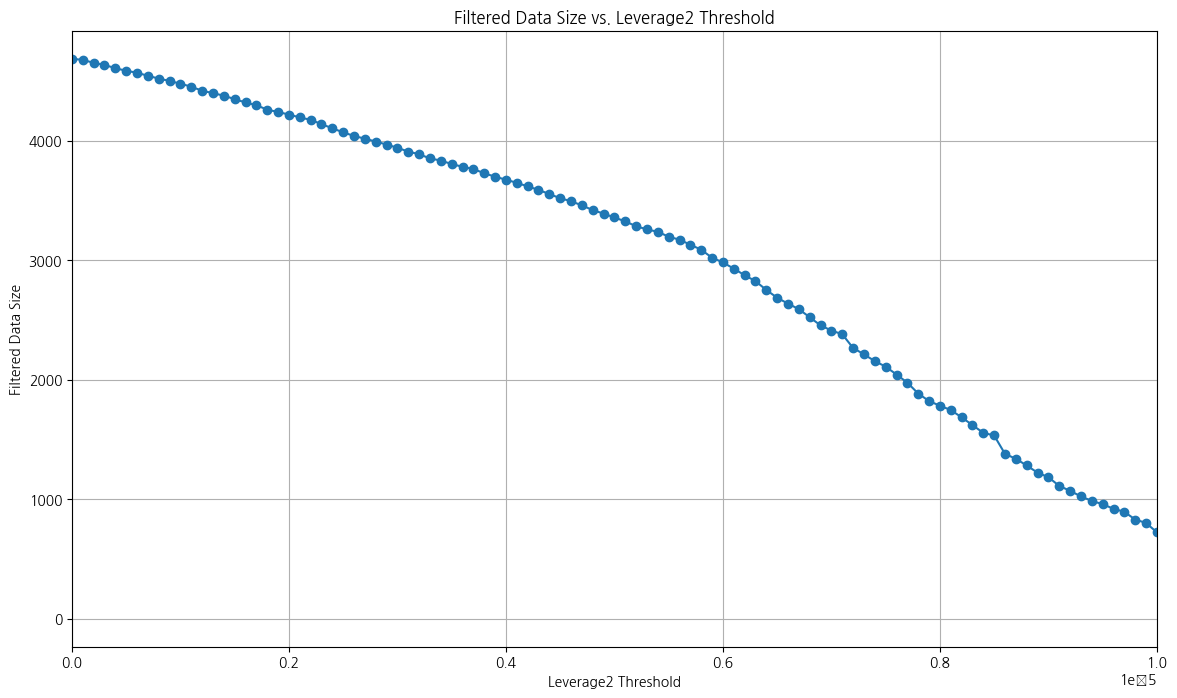

In [22]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# # threshold에 따른 filtered_data_leverage2의 크기
# thresholds = np.arange(0.0, 1.0, 1.0e-7)
# filtered_data_sizes = []

# for threshold in tqdm(thresholds):
#     filtered_data = data[data['leverage2'] > threshold]
#     filtered_data_sizes.append(len(filtered_data))

# 그래프 그리기
plt.figure(figsize=(14, 8))
plt.plot(thresholds, filtered_data_sizes, marker='o')
plt.xlabel('Leverage2 Threshold')
plt.xlim(0, 1.0e-5)
plt.ylabel('Filtered Data Size')
plt.title('Filtered Data Size vs. Leverage2 Threshold')
plt.grid(True)
plt.show()

In [24]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# CSV 파일 로드
abnormal_cases_df = pd.read_csv('abnormal_cases.csv')
data = pd.read_csv('result_table/result_pca_insert0.003_bpic2012_O_ACCEPTED-COMPLETE_clean.csv')

# abnormal_cases_df의 컬럼 이름 변경
abnormal_cases_df.columns = ['Case']

# data와 abnormal_cases_df 간의 일치하는 케이스 찾기
data['Anomaly'] = data['Case'].isin(abnormal_cases_df['Case']).map({True: 'Anomaly', False: 'Normal'})

# 랜덤으로 anomaly 탐지하는 방식
np.random.seed(42)  # 재현성을 위해 시드 고정
data['Prediction'] = np.random.choice(['Anomaly', 'Normal'], size=len(data))

# F1 score를 기준으로 Low, Medium, High 구간 설정
f1_scores = []
predictions = []

for _ in range(100):
    np.random.seed()  # 시드를 매번 다르게 설정
    current_prediction = np.random.choice(['Anomaly', 'Normal'], size=len(data))
    data['Prediction'] = current_prediction
    
    precision = precision_score(data['Anomaly'], data['Prediction'], pos_label='Anomaly')
    recall = recall_score(data['Anomaly'], data['Prediction'], pos_label='Anomaly')
    f1 = f1_score(data['Anomaly'], data['Prediction'], pos_label='Anomaly')
    
    f1_scores.append(f1)
    predictions.append(current_prediction)

# 가장 높은, 중간, 낮은 F1 Score를 가진 prediction을 저장
def save_representative_predictions(f1_scores, predictions):
    if f1_scores:
        f1_scores_sorted = sorted(zip(f1_scores, predictions), key=lambda x: x[0])
        lowest_f1, lowest_pred = f1_scores_sorted[0]
        median_f1, median_pred = f1_scores_sorted[len(f1_scores_sorted) // 2]
        highest_f1, highest_pred = f1_scores_sorted[-1]

        # 가장 낮은 F1 Score 저장
        data['Prediction'] = lowest_pred
        filtered_data = data[data['Prediction'] == 'Normal'] # 예측이 Normal인 경우를 저장
        if not filtered_data.empty:
            filtered_data[['Case']].to_csv(f'C:/Users/yeon1/Leverage_Eventlog/Leverage_Ko/filtered_data_random_low_{lowest_f1:.3f}.csv', index=False)

        # 중간 F1 Score 저장
        data['Prediction'] = median_pred
        filtered_data = data[data['Prediction'] == 'Normal']
        if not filtered_data.empty:
            filtered_data[['Case']].to_csv(f'C:/Users/yeon1/Leverage_Eventlog/Leverage_Ko/filtered_data_random_medium_{median_f1:.3f}.csv', index=False)

        # 가장 높은 F1 Score 저장
        data['Prediction'] = highest_pred
        filtered_data = data[data['Prediction'] == 'Normal']
        if not filtered_data.empty:
            filtered_data[['Case']].to_csv(f'C:/Users/yeon1/Leverage_Eventlog/Leverage_Ko/filtered_data_random_high_{highest_f1:.3f}.csv', index=False)

# 대표적인 predictions 저장
save_representative_predictions(f1_scores, predictions)


Low F1 Score Cases: 2313
Medium F1 Score Cases: 2290
High F1 Score Cases: 2321


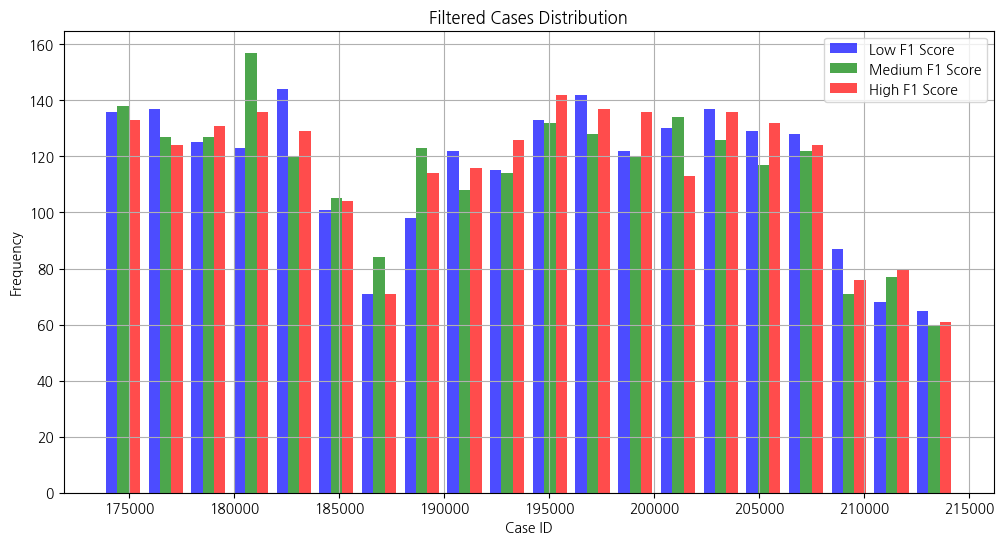

In [17]:
# df11, df22, df33 분포 비교

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# CSV 파일 로드
df11 = pd.read_csv('filtered_data_random_low.csv')
df22 = pd.read_csv('filtered_data_random_medium.csv')
df33 = pd.read_csv('filtered_data_random_high.csv')

# 각 데이터프레임의 'Case' 컬럼을 Series로 변환
cases11 = df11['Case']
cases22 = df22['Case']
cases33 = df33['Case']

# 각 데이터프레임의 'Case' 컬럼을 리스트로 변환
cases11_list = cases11.tolist()
cases22_list = cases22.tolist()
cases33_list = cases33.tolist()

# 각 데이터프레임의 'Case' 컬럼의 길이 출력
print(f'Low F1 Score Cases: {len(cases11)}')
print(f'Medium F1 Score Cases: {len(cases22)}')
print(f'High F1 Score Cases: {len(cases33)}')

# 각 데이터프레임의 'Case' 컬럼의 분포 비교
plt.figure(figsize=(12, 6))
plt.hist([cases11_list, cases22_list, cases33_list], bins=20, color=['blue', 'green', 'red'], label=['Low F1 Score', 'Medium F1 Score', 'High F1 Score'], alpha=0.7)
plt.title('Filtered Cases Distribution')
plt.xlabel('Case ID')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
# 0. Normal만 남기는 방식
filtered_data_normal = data[data['Anomaly'] == 'Normal']
filtered_data_normal[['Case']].to_csv('filtered_data_normal.csv', index=False)